In the README make sure to mention - scaling data before splitting it could cause data leak.

In [302]:
import numpy as np
import pandas as pd # For working with spreadsheet data
from matplotlib import pyplot as plt # For plotting data
import matplotlib.dates as mdates
import seaborn as sns
import math # For splitting the data into different sets for the NN
import datetime # Converting dates in the DataFrame into integers

from sklearn.model_selection import train_test_split # For separating the data into training and testing sets
from sklearn.preprocessing import StandardScaler # For preprocessing the data before it's passed to the model
from sklearn.svm import SVR # One of the algorithms being used to forecast the price
from sklearn.model_selection import cross_val_score # Metric to test the model's accuracy when hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score # Metrics to see the model's accuracy after it's been trained

# For the deep learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# For hyperparameter optimization
import optuna

# For saving the neural network weights
import os

# Data Ingestion and Cleaning

In [577]:
# Getting the spreadsheet data
data = pd.read_csv("Ethereum Data/ETH_5Years.csv")

In [420]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,207.485992,1749300000
...,...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,1810.088623,7534051038


In [578]:
# Deleting this row since it isn't important here
data.drop(['Adj Close'], axis = 1, inplace = True)
data

,Date,Open,High,Low,Close,Volume
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


In [422]:
data['Close'].values

array([ 197.380997,  198.871994,  200.634995, ..., 1795.546021,
       1810.088623, 1816.458984])

# Visualizing the Data

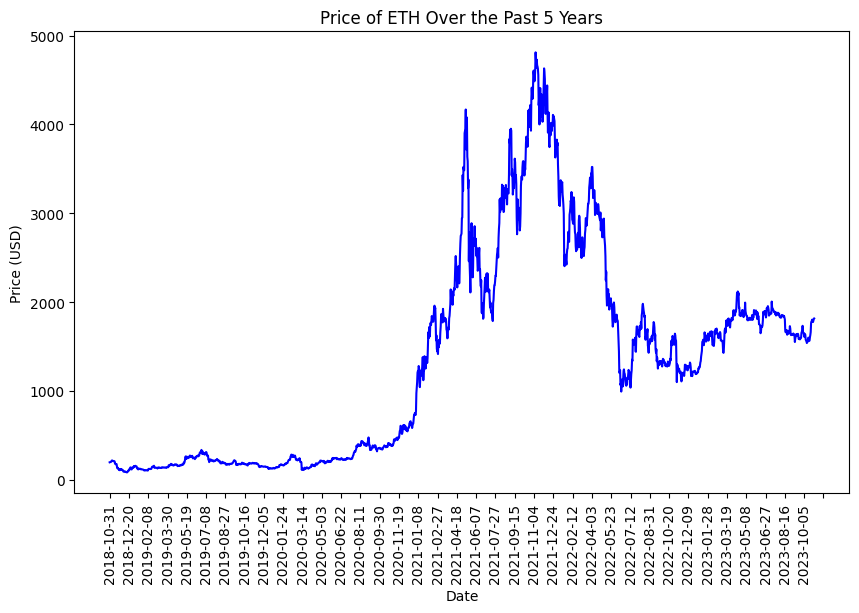

In [423]:
# Plotting ETH price
plt.figure(figsize = (10, 6))
plt.plot(data['Date'], data['Close'], color="blue")

plt.title("Price of ETH Over the Past 5 Years")
plt.xlabel("Date")
plt.xticks(np.arange(0, 1900, step=50),rotation=90) # ticks once every 50 days
plt.ylabel("Price (USD)")

plt.show()

In [579]:
# Converting the date value to an integer so it can be used by the model
data['Date Num'] = pd.to_datetime(data['Date'])
data['Date Num'] = data['Date Num'].map(mdates.date2num)

In [580]:
data

,Date,Open,High,Low,Close,Volume,Date Num
0,2018-10-31,197.649002,198.337997,196.531006,197.380997,1442380000,17835.0
1,2018-11-01,197.537003,203.753998,197.328003,198.871994,1336700000,17836.0
2,2018-11-02,198.981995,201.268997,198.755005,200.634995,1451870000,17837.0
3,2018-11-03,200.740005,200.740005,199.524994,200.186005,1307150000,17838.0
4,2018-11-04,200.158005,211.272003,198.985992,207.485992,1749300000,17839.0
...,...,...,...,...,...,...,...
1822,2023-10-27,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,19657.0
1823,2023-10-28,1780.084229,1800.605347,1773.436646,1776.618164,4226112731,19658.0
1824,2023-10-29,1776.563965,1810.488647,1766.052979,1795.546021,4358528382,19659.0
1825,2023-10-30,1795.589111,1829.249512,1779.364502,1810.088623,7534051038,19660.0


In [581]:
# Rearranging the columns
cols = data.columns.tolist()
cols = [cols[0]] + cols[-1:] + cols[1:-1]
data = data[cols]
data

,Date,Date Num,Open,High,Low,Close,Volume
0,2018-10-31,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000
1,2018-11-01,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000
2,2018-11-02,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000
3,2018-11-03,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000
4,2018-11-04,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000
...,...,...,...,...,...,...,...
1822,2023-10-27,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771
1823,2023-10-28,19658.0,1780.084229,1800.605347,1773.436646,1776.618164,4226112731
1824,2023-10-29,19659.0,1776.563965,1810.488647,1766.052979,1795.546021,4358528382
1825,2023-10-30,19660.0,1795.589111,1829.249512,1779.364502,1810.088623,7534051038


# Feature Engineering and Preprocessing

In [427]:
# Creating a constant to store the number of days in the future to predict the price
DAYS_IN_FUTURE = 3
length = len(data)

# Adding an extra column for the future price and setting the value of each row equal to the 'Close' value DAYS_IN_FUTURE days in the future
future_price = [data['Close'].loc[x + DAYS_IN_FUTURE] for x in range(length - DAYS_IN_FUTURE)]

# Getting rid of last DAYS_IN_FUTURE rows since there is no future price value for those days
for x in range(DAYS_IN_FUTURE):
    data.drop(length - x - 1, inplace = True)

C:\Users\ayan_\AppData\Local\Temp\ipykernel_17008\1844786035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(length - x - 1, inplace = True)
C:\Users\ayan_\AppData\Local\Temp\ipykernel_17008\1844786035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(length - x - 1, inplace = True)
C:\Users\ayan_\AppData\Local\Temp\ipykernel_17008\1844786035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(len

In [428]:
# Creating the column in the DataFrame
data[f"{DAYS_IN_FUTURE} Days Future Price"] = future_price
data

C:\Users\ayan_\AppData\Local\Temp\ipykernel_17008\1807076990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{DAYS_IN_FUTURE} Days Future Price"] = future_price


,Date,Date Num,Open,High,Low,Close,Volume,3 Days Future Price
0,2018-10-31,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,2018-11-01,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,2018-11-02,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,2018-11-03,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,2018-11-04,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...,...
1819,2023-10-24,19654.0,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,2023-10-25,19655.0,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,2023-10-26,19656.0,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,2023-10-27,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


In [429]:
# Calculate correlation matrix
temp = data.drop('Date', axis=1)
matrix = temp.corr()

# Print correlation matrix
print(matrix)

                     Date Num      Open      High       Low     Close  \
Date Num             1.000000  0.618811  0.613348  0.626303  0.618549   
Open                 0.618811  1.000000  0.999136  0.998177  0.997677   
High                 0.613348  0.999136  1.000000  0.997886  0.998798   
Low                  0.626303  0.998177  0.997886  1.000000  0.998826   
Close                0.618549  0.997677  0.998798  0.998826  1.000000   
Volume               0.095456  0.424172  0.438358  0.398969  0.420918   
3 Days Future Price  0.617307  0.991502  0.992547  0.992482  0.993669   

                       Volume  3 Days Future Price  
Date Num             0.095456             0.617307  
Open                 0.424172             0.991502  
High                 0.438358             0.992547  
Low                  0.398969             0.992482  
Close                0.420918             0.993669  
Volume               1.000000             0.420532  
3 Days Future Price  0.420532             1.

<Axes: >

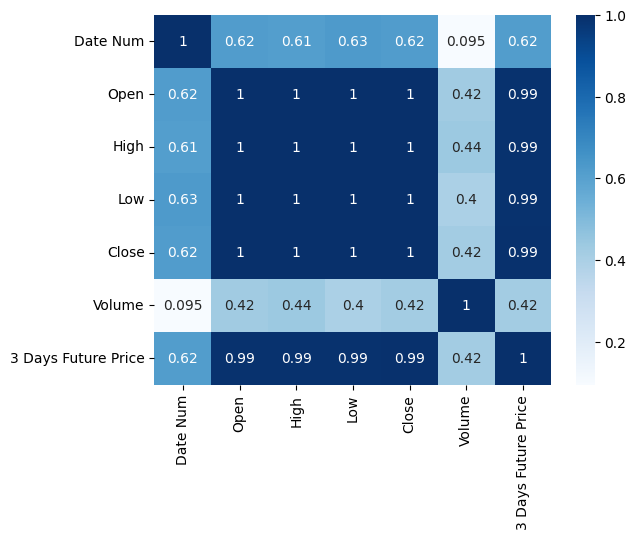

In [430]:
# Visualizing the correlation matrix
sns.heatmap(matrix, annot=True, cmap="Blues")

# Splitting the Data

In [516]:
# Splitting data into training and test
train_threshold = math.floor(0.7 * len(data))
train_threshold

1276

In [517]:
# train = data[0:train_threshold, :]
# test = data[train_threshold:, :]
train = data.head(train_threshold)
test = data.tail(len(data) - train_threshold)

In [518]:
train

,Date,Date Num,Open,High,Low,Close,Volume,3 Days Future Price
0,2018-10-31,17835.0,197.649002,198.337997,196.531006,197.380997,1442380000,200.186005
1,2018-11-01,17836.0,197.537003,203.753998,197.328003,198.871994,1336700000,207.485992
2,2018-11-02,17837.0,198.981995,201.268997,198.755005,200.634995,1451870000,209.091003
3,2018-11-03,17838.0,200.740005,200.740005,199.524994,200.186005,1307150000,218.451996
4,2018-11-04,17839.0,200.158005,211.272003,198.985992,207.485992,1749300000,217.182999
...,...,...,...,...,...,...,...,...
1271,2022-04-24,19106.0,2937.347168,2961.882080,2922.128662,2922.732666,9696829579,2888.929688
1272,2022-04-25,19107.0,2922.990234,3018.415527,2804.507080,3009.393555,22332690614,2936.940918
1273,2022-04-26,19108.0,3008.946289,3026.415039,2786.253174,2808.298340,19052045399,2815.601807
1274,2022-04-27,19109.0,2808.645996,2911.877441,2802.273438,2888.929688,17419284041,2730.186768


In [519]:
test

,Date,Date Num,Open,High,Low,Close,Volume,3 Days Future Price
1276,2022-04-29,19111.0,2936.776611,2943.445801,2782.435303,2815.601807,18771041399,2857.410400
1277,2022-04-30,19112.0,2815.533447,2836.827637,2727.406250,2730.186768,13520941867,2783.476318
1278,2022-05-01,19113.0,2729.994141,2838.704346,2728.078857,2827.756104,15332730152,2940.644775
1279,2022-05-02,19114.0,2827.614014,2874.145996,2785.522949,2857.410400,18609741545,2749.213135
1280,2022-05-03,19115.0,2857.152344,2859.193359,2762.118652,2783.476318,13026093219,2694.979736
...,...,...,...,...,...,...,...,...
1819,2023-10-24,19654.0,1766.014648,1852.684448,1758.690063,1784.437500,15888690475,1780.045288
1820,2023-10-25,19655.0,1784.905029,1814.484741,1762.147095,1787.397583,9439066475,1776.618164
1821,2023-10-26,19656.0,1787.481934,1865.095215,1764.013062,1804.039307,11196672635,1795.546021
1822,2023-10-27,19657.0,1803.794922,1804.135864,1751.440063,1780.045288,7493399771,1810.088623


In [520]:
# Function to split each set (training and testing) by features and targets - i.e. separating them by x and y variables
def create_datasets(df):
    x = df[['Date Num', 'Open', 'Close']]
    y = df[f'{DAYS_IN_FUTURE} Days Future Price']
    return (np.array(x), np.array(y))

In [521]:
x_train, y_train = create_datasets(train)
x_test, y_test = create_datasets(test)

In [522]:
print(x_train)
print(x_train.shape)

[[17835.         197.649002   197.380997]
 [17836.         197.537003   198.871994]
 [17837.         198.981995   200.634995]
 ...
 [19108.        3008.946289  2808.29834 ]
 [19109.        2808.645996  2888.929688]
 [19110.        2888.849854  2936.940918]]
(1276, 3)


In [523]:
print(x_test)
print(x_test.shape)

[[19111.        2936.776611  2815.601807]
 [19112.        2815.533447  2730.186768]
 [19113.        2729.994141  2827.756104]
 ...
 [19656.        1787.481934  1804.039307]
 [19657.        1803.794922  1780.045288]
 [19658.        1780.084229  1776.618164]]
(548, 3)


In [524]:
print(y_train)
print(y_train.shape)

[ 200.186005  207.485992  209.091003 ... 2815.601807 2730.186768
 2827.756104]
(1276,)


In [525]:
print(y_test)
print(y_test.shape)

[2857.4104   2783.476318 2940.644775 2749.213135 2694.979736 2636.093018
 2517.459961 2245.43042  2343.510986 2072.108643 1961.701538 2014.418213
 2056.273926 2145.706787 2022.725952 2090.40918  1916.656128 2018.336182
 1961.315674 1974.518311 2043.170166 1972.181885 1978.982788 1944.827881
 1803.91333  1724.922852 1757.941772 1812.031006 1996.441284 1942.328003
 1823.569336 1834.150513 1775.078613 1801.609497 1805.204956 1859.289673
 1814.04834  1793.572266 1789.82605  1665.042236 1529.663452 1445.216553
 1204.582764 1211.662842 1233.206421 1067.730713 1086.519287  993.63678
 1127.656494 1127.642456 1124.824585 1051.421875 1143.386719 1226.844727
 1243.446899 1199.831665 1193.680664 1144.579224 1098.943848 1067.298828
 1059.767334 1066.512817 1073.766968 1151.059082 1134.541016 1186.973999
 1237.593384 1222.506226 1216.978271 1168.401611 1097.236572 1038.19165
 1113.587158 1191.526245 1233.12915  1352.626465 1338.635742 1578.717896
 1542.97522  1520.200684 1576.749512 1537.405151 1549

In [526]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1 ,1)

In [527]:
y_train.shape

(1276, 1)

In [528]:
y_test.shape

(548, 1)

# Scaling the Data

In [529]:
# Scale the features data for preprocessing
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

x_train_scaled = x_scaler.fit_transform(x_train)
y_train_scaled = y_scaler.fit_transform(y_train)
x_test_scaled = x_scaler.transform(x_test)
y_test_scaled = y_scaler.transform(y_test)

In [530]:
x_train_scaled

array([[0.00000000e+00, 2.39894853e-02, 2.39166633e-02],
       [7.84313725e-04, 2.39657858e-02, 2.42320327e-02],
       [1.56862745e-03, 2.42715530e-02, 2.46049353e-02],
       ...,
       [9.98431373e-01, 6.18873375e-01, 5.76166945e-01],
       [9.99215686e-01, 5.76488880e-01, 5.93221749e-01],
       [1.00000000e+00, 5.93460398e-01, 6.03376883e-01]])

In [531]:
x_test_scaled

array([[1.00078431, 0.60360193, 0.57771174],
       [1.00156863, 0.5779463 , 0.55964511],
       [1.00235294, 0.55984577, 0.58028257],
       ...,
       [1.42823529, 0.3604057 , 0.36375029],
       [1.42901961, 0.36385761, 0.35867517],
       [1.42980392, 0.35884031, 0.35795028]])

In [532]:
y_train_scaled

array([[0.02450997],
       [0.02605403],
       [0.02639351],
       ...,
       [0.57771174],
       [0.55964511],
       [0.58028257]])

In [533]:
y_test_scaled

array([[0.58655492],
       [0.5709167 ],
       [0.60416031],
       [0.56366949],
       [0.55219827],
       [0.5397428 ],
       [0.51465003],
       [0.45711148],
       [0.47785707],
       [0.42045119],
       [0.39709834],
       [0.40824875],
       [0.4171019 ],
       [0.43601836],
       [0.41000597],
       [0.42432204],
       [0.38757053],
       [0.40907746],
       [0.39701673],
       [0.39980929],
       [0.41433024],
       [0.3993151 ],
       [0.4007536 ],
       [0.3935293 ],
       [0.36372364],
       [0.34701591],
       [0.35399993],
       [0.36544066],
       [0.40444635],
       [0.39300053],
       [0.3678812 ],
       [0.37011928],
       [0.35762464],
       [0.36323634],
       [0.36399684],
       [0.37543661],
       [0.36586736],
       [0.36153634],
       [0.36074396],
       [0.33435021],
       [0.30571546],
       [0.2878536 ],
       [0.23695576],
       [0.2384533 ],
       [0.24301011],
       [0.20800938],
       [0.21198346],
       [0.192

In [534]:
# Changing the shape from (n, 1) to (n, )
y_train_scaled = y_train_scaled.ravel()
y_test_scaled = y_test_scaled.ravel()

# SVR Hyperparameter Tuning

In [535]:
# Train the SVR model in a way that optimizes the model's hyperparameters
def optimize_svr(trial):
    # Suggesting possible values to test for each hyperparameter
    c = trial.suggest_float("C", 1000, 5000, log = True)
    gamma = trial.suggest_float("gamma", 1e-5, 1e-1, log = True)
    
    # Creating the model to use for testing
    model = SVR(kernel = 'rbf', C = c, gamma = gamma)
    # Calculate how well a given model with certain hyperparameter performs
    score = np.mean(cross_val_score(model, x_train_scaled, y_train_scaled, cv = 5, scoring = 'neg_mean_squared_error'))
    accuracy = score.mean()
    
    # The metric being used to determine how effective a model is with certain hyperparameters
    return accuracy

In [549]:
# Creating the study object
study = optuna.create_study(direction = 'maximize')
# Experimenting with different hyperparameter values to find the optimal values
study.optimize(optimize_svr, n_trials = 150)

# Information about the most successful trial
print("Best trial:")
trial = study.best_trial

# The model hyperparameters that lead to maximum accuracy
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-01-21 11:29:16,821] A new study created in memory with name: no-name-b899be31-4c4d-4b76-8b8e-9ab0f2228cad
[I 2024-01-21 11:29:16,957] Trial 0 finished with value: -0.0041161419709166746 and parameters: {'C': 2370.527648140779, 'gamma': 0.016916197099251164}. Best is trial 0 with value: -0.0041161419709166746.
[I 2024-01-21 11:29:17,005] Trial 1 finished with value: -0.0038905096802442063 and parameters: {'C': 2207.309882381935, 'gamma': 0.0012427286040599735}. Best is trial 1 with value: -0.0038905096802442063.
[I 2024-01-21 11:29:17,053] Trial 2 finished with value: -0.0038516117493451137 and parameters: {'C': 2152.977872540896, 'gamma': 0.0009768177909100725}. Best is trial 2 with value: -0.0038516117493451137.
[I 2024-01-21 11:29:17,087] Trial 3 finished with value: -0.004009072806425707 and parameters: {'C': 2583.52378717146, 'gamma': 0.0001721430207395503}. Best is trial 2 with value: -0.0038516117493451137.
[I 2024-01-21 11:29:17,134] Trial 4 finished with value: -0.00406

Best trial:
Value: -0.0035326984460449665
Params:
    C: 4659.416871292613
    gamma: 0.0004743802217030187


In [550]:
# Getting the best values of each hyperparameter 
params = study.best_params

# Building the SVR Model

In [551]:
def build_model():
    # Passing in optimal hyperparameters
    model = SVR(kernel = 'rbf', C = params['C'], gamma = params['gamma'])
    # Fitting the model to the training data set
    model.fit(x_train_scaled, y_train_scaled)
    
    return model

In [552]:
# Creating the model
model = build_model()

In [553]:
# Testing the model on the test set
predictions = model.predict(x_test_scaled)

In [554]:
# Evaluating its performance
mse = mean_squared_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0007839294897903621
R-squared: 0.7878267364702923


In [555]:
predictions = predictions.reshape(-1, 1)

In [556]:
# Rescale the predictions
predictions_rescaled = y_scaler.inverse_transform(predictions)

In [557]:
# Creating a DataFrame to hold just the Date values
test_date = x_test[:, [0]]
df_test_date = pd.DataFrame(test_date, columns = ['Date'])
df_test_date

,Date
0,19111.0
1,19112.0
2,19113.0
3,19114.0
4,19115.0
...,...
543,19654.0
544,19655.0
545,19656.0
546,19657.0


In [558]:
# Transforming the Date values back into a readable form
df_test_date = df_test_date.map(mdates.num2date)
df_test_date = df_test_date['Date'].apply(lambda x : str(x).split(' ')[0])
test_date = df_test_date.to_numpy()
test_date

array(['2022-04-29', '2022-04-30', '2022-05-01', '2022-05-02',
       '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06',
       '2022-05-07', '2022-05-08', '2022-05-09', '2022-05-10',
       '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-14',
       '2022-05-15', '2022-05-16', '2022-05-17', '2022-05-18',
       '2022-05-19', '2022-05-20', '2022-05-21', '2022-05-22',
       '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
       '2022-05-27', '2022-05-28', '2022-05-29', '2022-05-30',
       '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03',
       '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07',
       '2022-06-08', '2022-06-09', '2022-06-10', '2022-06-11',
       '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
       '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19',
       '2022-06-20', '2022-06-21', '2022-06-22', '2022-06-23',
       '2022-06-24', '2022-06-25', '2022-06-26', '2022-06-27',
       '2022-06-28', '2022-06-29', '2022-06-30', '2022-

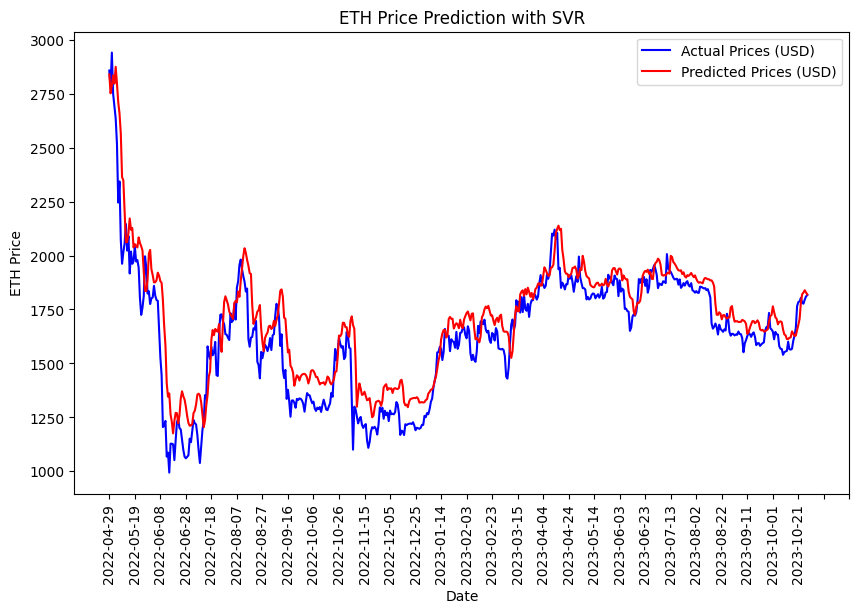

In [559]:
# Plotting performance
plt.figure(figsize = (10, 6))
plt.plot(test_date, y_test, label = "Actual Prices (USD)", color = "blue")
plt.plot(test_date, predictions_rescaled, label = "Predicted Prices (USD)", color = "red")

plt.title("ETH Price Prediction with SVR")
plt.xlabel("Date")
plt.ylabel("ETH Price")
plt.xticks(np.arange(0, 600, step=20),rotation=90) # ticks once every 20 days
plt.legend()

plt.show()

# Preparing the Data for the LSTM RNN

For the LSTM neural network, we can reshape the feature datasets into 3D arrays to use multiple days' worth of data to predict the future price.

In [367]:
# Reshaping feature datasets to account to use the past `timestep` days to predict the future price
def reshape(x_set, y_set, timestep):
    x, y = [], []
    for i in range(len(x_set) - timestep):
        x.append(x_set[i:(i + timestep)])
        y.append(y_set[i + timestep])
    return np.array(x), np.array(y)

In [368]:
# Number of previous days to use to predict
TIMESTEP = 15
# Create x and y datasets
x_train_scaled_reshaped, y_train_scaled_reshaped = reshape(x_train_scaled, y_train_scaled, TIMESTEP)
x_test_scaled_reshaped, y_test_scaled_reshaped = reshape(x_test_scaled, y_test_scaled, TIMESTEP)

# Display the shapes of the resulting arrays
print("x_train shape:", x_train_scaled_reshaped.shape)
print("y_train shape:", y_train_scaled_reshaped.shape)
print("x_test shape:", x_test_scaled_reshaped.shape)
print("y_test shape:", y_test_scaled_reshaped.shape)

x_train shape: (1261, 15, 3)
y_train shape: (1261,)
x_test shape: (533, 15, 3)
y_test shape: (533,)


In [369]:
# Creating training and validation sets for the neural network
x_train_scaled_reshaped, x_valid_scaled_reshaped, y_train_scaled_reshaped, y_valid_scaled_reshaped = train_test_split(x_train_scaled_reshaped, y_train_scaled_reshaped, test_size = 0.2)

In [370]:
print("x_train shape:", x_train_scaled_reshaped.shape)
print("y_train shape:", y_train_scaled_reshaped.shape)
print("x_valid shape:", x_valid_scaled_reshaped.shape)
print("y_valid shape:", y_valid_scaled_reshaped.shape)

x_train shape: (1008, 15, 3)
y_train shape: (1008,)
x_valid shape: (253, 15, 3)
y_valid shape: (253,)


# Hyperparameter Tuning the LSTM RNN

In [560]:
def optimize_lstm(trial):
    model = Sequential()

    # Initial LSTM layer
    model.add(LSTM(units = trial.suggest_int("first_layer_units", 50, 100), # Testing between 50-100 units
                   return_sequences = True, # 
                   input_shape = (x_train_scaled_reshaped.shape[1], x_train_scaled_reshaped.shape[2]))) # Setting the input shape equal to the number of days to use for prediction (TIMESTEP) and the number of features being used (3)
    model.add(Dropout(trial.suggest_float("first_layer_dropout", 0.15, 0.25))) # Regularization technique to prevent overfitting; switches some neurons off when the network adjusts its weights, allowing other neurons to learn better
                                                                               # Testing between 15-25% 
    
    model.add(LSTM(units = trial.suggest_int("second_layer_units", 50, 100), # Testing between 50-100 units
                   return_sequences = False))
    model.add(Dropout(trial.suggest_float("second_layer_dropout", 0.15, 0.25))) # Testing between 15-25%

    # 1 unit since we are predicting just one value (future price)
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    # Getting the model's training stats
    history = model.fit(x_train_scaled_reshaped, y_train_scaled_reshaped, epochs = 15, batch_size = 10, validation_data = (x_valid_scaled_reshaped, y_valid_scaled_reshaped))

    # Using the loss of the last epoch to measure the model's effectiveness
    return history.history['val_loss'][-1]

In [561]:
# Creating the Study object to find the optimal values
study = optuna.create_study(direction = 'minimize')
# Finding optimal hyperparameters
study.optimize(optimize_lstm, n_trials = 100)

# Printing information about the best performing trial
print("Best trial")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-01-21 11:44:53,374] A new study created in memory with name: no-name-9ee49475-b122-4547-8d9b-1f84456f951d


Epoch 1/15
101/101 [==============================] - 18s 45ms/step - loss: 0.0813 - val_loss: 0.0263
Epoch 2/15
101/101 [==============================] - 3s 32ms/step - loss: 0.0432 - val_loss: 0.0238
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0331 - val_loss: 0.0204
Epoch 4/15
101/101 [==============================] - 3s 32ms/step - loss: 0.0383 - val_loss: 0.0204
Epoch 5/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0329 - val_loss: 0.0208
Epoch 6/15
101/101 [==============================] - 3s 35ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 7/15
101/101 [==============================] - 3s 34ms/step - loss: 0.0359 - val_loss: 0.0171
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0329 - val_loss: 0.0346
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0337 - val_loss: 0.0207
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0276 - val_l

[I 2024-01-21 11:45:50,957] Trial 0 finished with value: 0.014474989846348763 and parameters: {'first_layer_units': 65, 'first_layer_dropout': 0.2385386562427837, 'second_layer_units': 66, 'second_layer_dropout': 0.21412569412793267}. Best is trial 0 with value: 0.014474989846348763.


Epoch 1/15
101/101 [==============================] - 35s 35ms/step - loss: 0.0762 - val_loss: 0.0318
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0416 - val_loss: 0.0227
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0362 - val_loss: 0.0274
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0324 - val_loss: 0.0222
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0311 - val_loss: 0.0186
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0175
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0279 - val_loss: 0.0161
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0299 - val_loss: 0.0156
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0277 - val_loss: 0.0268
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0321 - val_l

[I 2024-01-21 11:46:59,797] Trial 1 finished with value: 0.020128650590777397 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.1918762408969476, 'second_layer_units': 65, 'second_layer_dropout': 0.1784023358132922}. Best is trial 0 with value: 0.014474989846348763.


Epoch 1/15
101/101 [==============================] - 7s 32ms/step - loss: 0.0677 - val_loss: 0.0365
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0469 - val_loss: 0.0464
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0361 - val_loss: 0.0217
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0324 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0326 - val_loss: 0.0176
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0328 - val_loss: 0.0185
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0281 - val_loss: 0.0156
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0300 - val_loss: 0.0155
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0299 - val_loss: 0.0148
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0283 - val_lo

[I 2024-01-21 11:47:40,312] Trial 2 finished with value: 0.018764033913612366 and parameters: {'first_layer_units': 86, 'first_layer_dropout': 0.1993289511438184, 'second_layer_units': 80, 'second_layer_dropout': 0.23438198521627976}. Best is trial 0 with value: 0.014474989846348763.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0838 - val_loss: 0.0319
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0413 - val_loss: 0.0301
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0448 - val_loss: 0.0243
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0381 - val_loss: 0.0329
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0348 - val_loss: 0.0217
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0366 - val_loss: 0.0255
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0373 - val_loss: 0.0163
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0321 - val_loss: 0.0173
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0345 - val_loss: 0.0193
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0309 - val_lo

[I 2024-01-21 11:48:18,590] Trial 3 finished with value: 0.014524498954415321 and parameters: {'first_layer_units': 69, 'first_layer_dropout': 0.18770500882916075, 'second_layer_units': 69, 'second_layer_dropout': 0.23223571228047185}. Best is trial 0 with value: 0.014474989846348763.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0810 - val_loss: 0.0282
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0408 - val_loss: 0.0242
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0370 - val_loss: 0.0212
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0338 - val_loss: 0.0226
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0374 - val_loss: 0.0237
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0338 - val_loss: 0.0165
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0316 - val_loss: 0.0379
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0330 - val_loss: 0.0189
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0269 - val_loss: 0.0145
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0305 - val_lo

[I 2024-01-21 11:48:57,469] Trial 4 finished with value: 0.012816639617085457 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.18960134080926877, 'second_layer_units': 60, 'second_layer_dropout': 0.18963891771347968}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0773 - val_loss: 0.0287
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0427 - val_loss: 0.0230
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0360 - val_loss: 0.0215
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0352 - val_loss: 0.0212
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0368 - val_loss: 0.0231
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0209
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0316 - val_loss: 0.0162
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0326 - val_loss: 0.0193
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0158
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0302 - val_lo

[I 2024-01-21 11:49:36,315] Trial 5 finished with value: 0.01615281030535698 and parameters: {'first_layer_units': 61, 'first_layer_dropout': 0.23882895424560643, 'second_layer_units': 82, 'second_layer_dropout': 0.24177153066265014}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0846 - val_loss: 0.0391
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0451 - val_loss: 0.0251
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0362 - val_loss: 0.0237
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0344 - val_loss: 0.0204
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0308 - val_loss: 0.0192
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0385 - val_loss: 0.0404
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0370 - val_loss: 0.0197
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0308 - val_loss: 0.0197
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0322 - val_loss: 0.0360
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0314 - val_lo

[I 2024-01-21 11:50:13,419] Trial 6 finished with value: 0.014002188108861446 and parameters: {'first_layer_units': 59, 'first_layer_dropout': 0.2367373897316255, 'second_layer_units': 63, 'second_layer_dropout': 0.22629925256953654}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0716 - val_loss: 0.0325
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0367 - val_loss: 0.0241
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0387 - val_loss: 0.0274
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0338 - val_loss: 0.0256
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0299 - val_loss: 0.0230
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0313 - val_loss: 0.0173
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0287 - val_loss: 0.0170
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0311 - val_loss: 0.0173
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0271 - val_loss: 0.0159
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0279 - val_lo

[I 2024-01-21 11:50:52,926] Trial 7 finished with value: 0.019576111808419228 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.21972270942046396, 'second_layer_units': 99, 'second_layer_dropout': 0.18104310396308498}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0655 - val_loss: 0.0265
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0449 - val_loss: 0.0332
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0393 - val_loss: 0.0288
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0365 - val_loss: 0.0328
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0362 - val_loss: 0.0182
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0319 - val_loss: 0.0224
Epoch 7/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0334 - val_loss: 0.0184
Epoch 8/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0284 - val_loss: 0.0155
Epoch 9/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0321 - val_loss: 0.0170
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0307 - val_lo

[I 2024-01-21 11:51:32,133] Trial 8 finished with value: 0.014604655094444752 and parameters: {'first_layer_units': 77, 'first_layer_dropout': 0.23711278635120375, 'second_layer_units': 94, 'second_layer_dropout': 0.24580243219223286}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0939 - val_loss: 0.0281
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0396 - val_loss: 0.0247
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0373 - val_loss: 0.0214
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0329 - val_loss: 0.0211
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0334 - val_loss: 0.0305
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0319 - val_loss: 0.0394
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0312 - val_loss: 0.0229
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0319 - val_loss: 0.0181
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0354 - val_loss: 0.0203
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0302 - val_lo

[I 2024-01-21 11:52:08,345] Trial 9 finished with value: 0.021410968154668808 and parameters: {'first_layer_units': 51, 'first_layer_dropout': 0.2174459382295817, 'second_layer_units': 66, 'second_layer_dropout': 0.19842578282512108}. Best is trial 4 with value: 0.012816639617085457.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0765 - val_loss: 0.0267
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0392 - val_loss: 0.0391
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0386 - val_loss: 0.0206
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0395 - val_loss: 0.0181
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0291 - val_loss: 0.0175
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0344 - val_loss: 0.0210
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0289 - val_loss: 0.0178
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0287 - val_loss: 0.0189
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0276 - val_loss: 0.0220
Epoch 10/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0260 - val_lo

[I 2024-01-21 11:52:45,075] Trial 10 finished with value: 0.012381967157125473 and parameters: {'first_layer_units': 83, 'first_layer_dropout': 0.1648334581835348, 'second_layer_units': 50, 'second_layer_dropout': 0.15525957500009954}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0838 - val_loss: 0.0293
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0368 - val_loss: 0.0243
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0340 - val_loss: 0.0224
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0348 - val_loss: 0.0230
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0356 - val_loss: 0.0270
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0313 - val_loss: 0.0186
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0325 - val_loss: 0.0163
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0158
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0282 - val_loss: 0.0247
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0274 - val_lo

[I 2024-01-21 11:53:22,014] Trial 11 finished with value: 0.01615922525525093 and parameters: {'first_layer_units': 84, 'first_layer_dropout': 0.16361477347553804, 'second_layer_units': 50, 'second_layer_dropout': 0.15037965277124343}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0797 - val_loss: 0.0257
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0377 - val_loss: 0.0227
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0360 - val_loss: 0.0216
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0359 - val_loss: 0.0205
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0355 - val_loss: 0.0180
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0285 - val_loss: 0.0264
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0324 - val_loss: 0.0205
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0287 - val_loss: 0.0169
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0289 - val_loss: 0.0150
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0289 - val_lo

[I 2024-01-21 11:53:59,203] Trial 12 finished with value: 0.013353876769542694 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.15779678672673694, 'second_layer_units': 52, 'second_layer_dropout': 0.15064594225140976}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0679 - val_loss: 0.0286
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0362 - val_loss: 0.0291
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0348 - val_loss: 0.0220
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0358 - val_loss: 0.0271
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0322 - val_loss: 0.0183
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0270 - val_loss: 0.0209
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0330 - val_loss: 0.0191
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0301 - val_loss: 0.0170
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0286 - val_loss: 0.0304
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0313 - val_lo

[I 2024-01-21 11:54:35,841] Trial 13 finished with value: 0.013168225064873695 and parameters: {'first_layer_units': 77, 'first_layer_dropout': 0.1742252622645753, 'second_layer_units': 57, 'second_layer_dropout': 0.16948015466198516}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0718 - val_loss: 0.0444
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0416 - val_loss: 0.0229
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0366 - val_loss: 0.0213
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0342 - val_loss: 0.0267
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0349 - val_loss: 0.0193
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0326 - val_loss: 0.0220
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0292 - val_loss: 0.0162
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_loss: 0.0162
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0309 - val_loss: 0.0290
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0304 - val_lo

[I 2024-01-21 11:55:13,481] Trial 14 finished with value: 0.014054019004106522 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.15220476291645565, 'second_layer_units': 57, 'second_layer_dropout': 0.19113612172546385}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0745 - val_loss: 0.0457
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0373 - val_loss: 0.0232
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0381 - val_loss: 0.0208
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0419 - val_loss: 0.0214
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0370 - val_loss: 0.0211
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0327 - val_loss: 0.0209
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0365 - val_loss: 0.0299
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0319 - val_loss: 0.0190
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0296 - val_loss: 0.0152
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0313 - val_lo

[I 2024-01-21 11:55:50,745] Trial 15 finished with value: 0.013686111196875572 and parameters: {'first_layer_units': 82, 'first_layer_dropout': 0.175551923690657, 'second_layer_units': 57, 'second_layer_dropout': 0.2102020315346801}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0788 - val_loss: 0.0252
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0359 - val_loss: 0.0260
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_loss: 0.0217
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0324 - val_loss: 0.0183
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0175
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_loss: 0.0228
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0298 - val_loss: 0.0294
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0309 - val_loss: 0.0202
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0288 - val_loss: 0.0156
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_lo

[I 2024-01-21 11:56:28,264] Trial 16 finished with value: 0.015514514409005642 and parameters: {'first_layer_units': 73, 'first_layer_dropout': 0.17169328049231003, 'second_layer_units': 76, 'second_layer_dropout': 0.16702043905272818}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0788 - val_loss: 0.0421
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0412 - val_loss: 0.0241
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0375 - val_loss: 0.0204
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0392 - val_loss: 0.0240
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0322 - val_loss: 0.0179
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0321 - val_loss: 0.0168
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0336 - val_loss: 0.0394
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0317 - val_loss: 0.0274
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0315 - val_loss: 0.0156
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0283 - val_lo

[I 2024-01-21 11:57:06,014] Trial 17 finished with value: 0.012887121178209782 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.18486655460272658, 'second_layer_units': 59, 'second_layer_dropout': 0.19136883896654167}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0701 - val_loss: 0.0307
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0390 - val_loss: 0.0276
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0378 - val_loss: 0.0217
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0330 - val_loss: 0.0221
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0316 - val_loss: 0.0217
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0322 - val_loss: 0.0172
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0265
Epoch 8/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0286 - val_loss: 0.0162
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0289 - val_loss: 0.0166
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0319 - val_lo

[I 2024-01-21 11:57:43,040] Trial 18 finished with value: 0.015081299468874931 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.1624070252703726, 'second_layer_units': 50, 'second_layer_dropout': 0.1634983564687568}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0905 - val_loss: 0.0589
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0422 - val_loss: 0.0296
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0339 - val_loss: 0.0225
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0314 - val_loss: 0.0225
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0326 - val_loss: 0.0194
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0333 - val_loss: 0.0268
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0318 - val_loss: 0.0179
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0297 - val_loss: 0.0168
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0264 - val_loss: 0.0189
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0285 - val_lo

[I 2024-01-21 11:58:20,586] Trial 19 finished with value: 0.014502168633043766 and parameters: {'first_layer_units': 81, 'first_layer_dropout': 0.1512759889050943, 'second_layer_units': 71, 'second_layer_dropout': 0.18153989235106263}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0554 - val_loss: 0.0300
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0318 - val_loss: 0.0218
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0333 - val_loss: 0.0205
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0371 - val_loss: 0.0198
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0305 - val_loss: 0.0162
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0282 - val_loss: 0.0197
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0291 - val_loss: 0.0179
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0288 - val_loss: 0.0154
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0257 - val_loss: 0.0205
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0271 - val_lo

[I 2024-01-21 11:59:03,699] Trial 20 finished with value: 0.020034950226545334 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.17996799831253504, 'second_layer_units': 88, 'second_layer_dropout': 0.15910747552642157}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 9s 36ms/step - loss: 0.0761 - val_loss: 0.0496
Epoch 2/15
101/101 [==============================] - 4s 44ms/step - loss: 0.0457 - val_loss: 0.0258
Epoch 3/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0390 - val_loss: 0.0222
Epoch 4/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0390 - val_loss: 0.0256
Epoch 5/15
101/101 [==============================] - 5s 45ms/step - loss: 0.0339 - val_loss: 0.0221
Epoch 6/15
101/101 [==============================] - 5s 45ms/step - loss: 0.0316 - val_loss: 0.0175
Epoch 7/15
101/101 [==============================] - 5s 45ms/step - loss: 0.0320 - val_loss: 0.0193
Epoch 8/15
101/101 [==============================] - 5s 48ms/step - loss: 0.0318 - val_loss: 0.0252
Epoch 9/15
101/101 [==============================] - 4s 38ms/step - loss: 0.0324 - val_loss: 0.0255
Epoch 10/15
101/101 [==============================] - 4s 41ms/step - loss: 0.0294 - val_lo

[I 2024-01-21 12:00:17,084] Trial 21 finished with value: 0.018208639696240425 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.18526661177189443, 'second_layer_units': 60, 'second_layer_dropout': 0.19147968584857725}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 16s 64ms/step - loss: 0.0814 - val_loss: 0.0470
Epoch 2/15
101/101 [==============================] - 3s 34ms/step - loss: 0.0389 - val_loss: 0.0223
Epoch 3/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0366 - val_loss: 0.0369
Epoch 4/15
101/101 [==============================] - 3s 33ms/step - loss: 0.0355 - val_loss: 0.0225
Epoch 5/15
101/101 [==============================] - 4s 37ms/step - loss: 0.0342 - val_loss: 0.0208
Epoch 6/15
101/101 [==============================] - 6s 55ms/step - loss: 0.0342 - val_loss: 0.0196
Epoch 7/15
101/101 [==============================] - 3s 34ms/step - loss: 0.0322 - val_loss: 0.0185
Epoch 8/15
101/101 [==============================] - 4s 41ms/step - loss: 0.0309 - val_loss: 0.0198
Epoch 9/15
101/101 [==============================] - 4s 44ms/step - loss: 0.0329 - val_loss: 0.0213
Epoch 10/15
101/101 [==============================] - 6s 55ms/step - loss: 0.0329 - val_l

[I 2024-01-21 12:01:27,963] Trial 22 finished with value: 0.012712244875729084 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.19427902335129874, 'second_layer_units': 55, 'second_layer_dropout': 0.20298701999919963}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 10s 45ms/step - loss: 0.0742 - val_loss: 0.0302
Epoch 2/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0395 - val_loss: 0.0244
Epoch 3/15
101/101 [==============================] - 5s 50ms/step - loss: 0.0380 - val_loss: 0.0237
Epoch 4/15
101/101 [==============================] - 5s 52ms/step - loss: 0.0366 - val_loss: 0.0203
Epoch 5/15
101/101 [==============================] - 4s 37ms/step - loss: 0.0347 - val_loss: 0.0317
Epoch 6/15
101/101 [==============================] - 4s 44ms/step - loss: 0.0305 - val_loss: 0.0197
Epoch 7/15
101/101 [==============================] - 3s 33ms/step - loss: 0.0297 - val_loss: 0.0163
Epoch 8/15
101/101 [==============================] - 5s 51ms/step - loss: 0.0310 - val_loss: 0.0179
Epoch 9/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0300 - val_loss: 0.0327
Epoch 10/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0284 - val_l

[I 2024-01-21 12:02:26,487] Trial 23 finished with value: 0.018101317808032036 and parameters: {'first_layer_units': 81, 'first_layer_dropout': 0.1999922886188026, 'second_layer_units': 54, 'second_layer_dropout': 0.17376253159832558}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.1004 - val_loss: 0.0267
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0434 - val_loss: 0.0242
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0362 - val_loss: 0.0224
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0355 - val_loss: 0.0206
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0354 - val_loss: 0.0210
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0371 - val_loss: 0.0233
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0371 - val_loss: 0.0203
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0326 - val_loss: 0.0171
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0328 - val_loss: 0.0152
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0328 - val_lo

[I 2024-01-21 12:03:06,305] Trial 24 finished with value: 0.01983957551419735 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.16888168450528315, 'second_layer_units': 53, 'second_layer_dropout': 0.20917365831141216}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0799 - val_loss: 0.0342
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0395 - val_loss: 0.0386
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0334 - val_loss: 0.0193
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0343 - val_loss: 0.0274
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0363 - val_loss: 0.0241
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0337 - val_loss: 0.0220
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0286 - val_loss: 0.0202
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0179
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0304 - val_loss: 0.0168
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0277 - val_lo

[I 2024-01-21 12:03:44,142] Trial 25 finished with value: 0.01630217395722866 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.193869320198563, 'second_layer_units': 62, 'second_layer_dropout': 0.2014215731654577}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 10s 35ms/step - loss: 0.0794 - val_loss: 0.0304
Epoch 2/15
101/101 [==============================] - 2s 18ms/step - loss: 0.0406 - val_loss: 0.0279
Epoch 3/15
101/101 [==============================] - 2s 19ms/step - loss: 0.0358 - val_loss: 0.0213
Epoch 4/15
101/101 [==============================] - 2s 19ms/step - loss: 0.0343 - val_loss: 0.0263
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0204
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0353 - val_loss: 0.0204
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0336 - val_loss: 0.0172
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_loss: 0.0267
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0285 - val_loss: 0.0252
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0277 - val_l

[I 2024-01-21 12:04:25,335] Trial 26 finished with value: 0.013134040869772434 and parameters: {'first_layer_units': 76, 'first_layer_dropout': 0.20731841325172048, 'second_layer_units': 55, 'second_layer_dropout': 0.1588558260617446}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0867 - val_loss: 0.0263
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0427 - val_loss: 0.0238
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0375 - val_loss: 0.0235
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0314 - val_loss: 0.0303
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0306 - val_loss: 0.0213
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0298 - val_loss: 0.0214
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0200
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0270 - val_loss: 0.0293
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0295 - val_loss: 0.0169
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0268 - val_lo

[I 2024-01-21 12:05:03,933] Trial 27 finished with value: 0.02321860007941723 and parameters: {'first_layer_units': 71, 'first_layer_dropout': 0.16842440776465853, 'second_layer_units': 71, 'second_layer_dropout': 0.17570086249549322}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0653 - val_loss: 0.0254
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0380 - val_loss: 0.0226
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0366 - val_loss: 0.0251
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0209
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0332 - val_loss: 0.0193
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0284 - val_loss: 0.0186
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0297 - val_loss: 0.0180
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0305 - val_loss: 0.0200
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0308 - val_loss: 0.0187
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0276 - val_lo

[I 2024-01-21 12:05:42,294] Trial 28 finished with value: 0.014022140763700008 and parameters: {'first_layer_units': 84, 'first_layer_dropout': 0.1773651336343332, 'second_layer_units': 61, 'second_layer_dropout': 0.18628057520122843}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0836 - val_loss: 0.0285
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0435 - val_loss: 0.0232
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0430 - val_loss: 0.0330
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0373 - val_loss: 0.0221
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0328 - val_loss: 0.0197
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0324 - val_loss: 0.0180
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0323 - val_loss: 0.0170
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0321 - val_loss: 0.0183
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_loss: 0.0307
Epoch 10/15
101/101 [==============================] - 2s 19ms/step - loss: 0.0337 - val_lo

[I 2024-01-21 12:06:20,048] Trial 29 finished with value: 0.03181435540318489 and parameters: {'first_layer_units': 79, 'first_layer_dropout': 0.1812744089107401, 'second_layer_units': 67, 'second_layer_dropout': 0.2165879100355238}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0754 - val_loss: 0.0257
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0435 - val_loss: 0.0226
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0384 - val_loss: 0.0230
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0326 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0328 - val_loss: 0.0219
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0311 - val_loss: 0.0170
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0276 - val_loss: 0.0153
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0282 - val_loss: 0.0226
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0317 - val_loss: 0.0180
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0264 - val_lo

[I 2024-01-21 12:06:59,552] Trial 30 finished with value: 0.013505467213690281 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.1937080043212857, 'second_layer_units': 74, 'second_layer_dropout': 0.20077917110573093}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0774 - val_loss: 0.0303
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0457 - val_loss: 0.0348
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0410 - val_loss: 0.0233
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0334 - val_loss: 0.0205
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0316 - val_loss: 0.0216
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0284 - val_loss: 0.0175
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0312 - val_loss: 0.0162
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0295 - val_loss: 0.0185
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0320 - val_loss: 0.0177
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0295 - val_lo

[I 2024-01-21 12:07:38,490] Trial 31 finished with value: 0.015685811638832092 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.18689639251901577, 'second_layer_units': 60, 'second_layer_dropout': 0.18790998995193892}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0968 - val_loss: 0.0366
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0433 - val_loss: 0.0266
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0379 - val_loss: 0.0224
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0343 - val_loss: 0.0215
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0339 - val_loss: 0.0259
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0368 - val_loss: 0.0182
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0316 - val_loss: 0.0175
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0327 - val_loss: 0.0171
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0177
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0299 - val_lo

[I 2024-01-21 12:08:16,218] Trial 32 finished with value: 0.016644546762108803 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.18306427468905687, 'second_layer_units': 58, 'second_layer_dropout': 0.19596291950017747}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0838 - val_loss: 0.0284
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0418 - val_loss: 0.0261
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0378 - val_loss: 0.0207
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0365 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0323 - val_loss: 0.0270
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0307 - val_loss: 0.0166
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0329 - val_loss: 0.0218
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0323 - val_loss: 0.0169
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0288 - val_loss: 0.0144
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0348 - val_lo

[I 2024-01-21 12:08:53,311] Trial 33 finished with value: 0.013377552852034569 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.18886345499407475, 'second_layer_units': 50, 'second_layer_dropout': 0.18280246781404758}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0895 - val_loss: 0.0370
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0403 - val_loss: 0.0264
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0382 - val_loss: 0.0346
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0341 - val_loss: 0.0363
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0360 - val_loss: 0.0209
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0333 - val_loss: 0.0171
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0294 - val_loss: 0.0178
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0309 - val_loss: 0.0165
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0258 - val_lo

[I 2024-01-21 12:09:31,184] Trial 34 finished with value: 0.013566989451646805 and parameters: {'first_layer_units': 99, 'first_layer_dropout': 0.193811695273906, 'second_layer_units': 54, 'second_layer_dropout': 0.17605943167775598}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0768 - val_loss: 0.0307
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0405 - val_loss: 0.0340
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0349 - val_loss: 0.0281
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0351 - val_loss: 0.0220
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0312 - val_loss: 0.0296
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0324 - val_loss: 0.0276
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0344 - val_loss: 0.0284
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0340 - val_loss: 0.0182
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0305 - val_loss: 0.0160
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0301 - val_lo

[I 2024-01-21 12:10:08,922] Trial 35 finished with value: 0.02383565343916416 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.17964990041267642, 'second_layer_units': 64, 'second_layer_dropout': 0.2049472181829311}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0858 - val_loss: 0.0363
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0413 - val_loss: 0.0248
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0371 - val_loss: 0.0449
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0343 - val_loss: 0.0226
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0349 - val_loss: 0.0212
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0343 - val_loss: 0.0184
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0312 - val_loss: 0.0487
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0321 - val_loss: 0.0158
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0322 - val_loss: 0.0144
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0302 - val_lo

[I 2024-01-21 12:10:46,878] Trial 36 finished with value: 0.013497992418706417 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.20194637538788074, 'second_layer_units': 58, 'second_layer_dropout': 0.21838065032941606}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 29ms/step - loss: 0.0888 - val_loss: 0.0313
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0358 - val_loss: 0.0308
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0346 - val_loss: 0.0213
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0330 - val_loss: 0.0202
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0309 - val_loss: 0.0185
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0332 - val_loss: 0.0187
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0291 - val_loss: 0.0262
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0256 - val_loss: 0.0158
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0271 - val_loss: 0.0162
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0280 - val_lo

[I 2024-01-21 12:11:25,866] Trial 37 finished with value: 0.01324258279055357 and parameters: {'first_layer_units': 86, 'first_layer_dropout': 0.18786984612779362, 'second_layer_units': 68, 'second_layer_dropout': 0.1959900968171746}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0619 - val_loss: 0.0269
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0369 - val_loss: 0.0222
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0381 - val_loss: 0.0225
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0335 - val_loss: 0.0237
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0351 - val_loss: 0.0411
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0354 - val_loss: 0.0168
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0291 - val_loss: 0.0161
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0274 - val_loss: 0.0174
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0290 - val_loss: 0.0259
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0288 - val_lo

[I 2024-01-21 12:12:05,833] Trial 38 finished with value: 0.017487382516264915 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.17139079105570446, 'second_layer_units': 81, 'second_layer_dropout': 0.1929017617862741}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0808 - val_loss: 0.0274
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0475 - val_loss: 0.0389
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0335 - val_loss: 0.0223
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0361 - val_loss: 0.0206
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0353 - val_loss: 0.0510
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0331 - val_loss: 0.0237
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0357 - val_loss: 0.0302
Epoch 8/15
101/101 [==============================] - 2s 18ms/step - loss: 0.0314 - val_loss: 0.0179
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0287 - val_loss: 0.0201
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0306 - val_lo

[I 2024-01-21 12:12:42,019] Trial 39 finished with value: 0.016521276906132698 and parameters: {'first_layer_units': 64, 'first_layer_dropout': 0.17622187449182164, 'second_layer_units': 64, 'second_layer_dropout': 0.18675120325452482}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0880 - val_loss: 0.0280
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0433 - val_loss: 0.0300
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0358 - val_loss: 0.0254
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0348 - val_loss: 0.0272
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0322 - val_loss: 0.0188
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0391 - val_loss: 0.0207
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0381 - val_loss: 0.0225
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0302 - val_loss: 0.0205
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0303 - val_loss: 0.0239
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0299 - val_lo

[I 2024-01-21 12:13:19,122] Trial 40 finished with value: 0.015270581468939781 and parameters: {'first_layer_units': 83, 'first_layer_dropout': 0.1840464308126832, 'second_layer_units': 52, 'second_layer_dropout': 0.20263156639288746}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0938 - val_loss: 0.0282
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0407 - val_loss: 0.0307
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0347 - val_loss: 0.0221
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0342 - val_loss: 0.0313
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0335 - val_loss: 0.0199
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0341 - val_loss: 0.0251
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0321 - val_loss: 0.0192
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0319 - val_loss: 0.0164
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0297 - val_loss: 0.0202
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0296 - val_lo

[I 2024-01-21 12:13:55,868] Trial 41 finished with value: 0.01379164308309555 and parameters: {'first_layer_units': 74, 'first_layer_dropout': 0.20548455911648, 'second_layer_units': 56, 'second_layer_dropout': 0.15767399464940085}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0833 - val_loss: 0.0259
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0376 - val_loss: 0.0232
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0398 - val_loss: 0.0223
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0370 - val_loss: 0.0201
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0357 - val_loss: 0.0195
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0290 - val_loss: 0.0179
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0322 - val_loss: 0.0164
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0278
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0299 - val_loss: 0.0247
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0299 - val_lo

[I 2024-01-21 12:14:33,118] Trial 42 finished with value: 0.015139306895434856 and parameters: {'first_layer_units': 80, 'first_layer_dropout': 0.206189131213894, 'second_layer_units': 55, 'second_layer_dropout': 0.17163529031928737}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0798 - val_loss: 0.0266
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0449 - val_loss: 0.0267
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0345 - val_loss: 0.0234
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0362 - val_loss: 0.0214
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0331 - val_loss: 0.0200
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0286 - val_loss: 0.0204
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0327 - val_loss: 0.0169
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0300 - val_loss: 0.0179
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0314 - val_loss: 0.0193
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0294 - val_lo

[I 2024-01-21 12:15:09,832] Trial 43 finished with value: 0.013171050697565079 and parameters: {'first_layer_units': 68, 'first_layer_dropout': 0.19673327750466657, 'second_layer_units': 60, 'second_layer_dropout': 0.1774306740783088}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0812 - val_loss: 0.0283
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0403 - val_loss: 0.0255
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0380 - val_loss: 0.0392
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0346 - val_loss: 0.0192
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0344 - val_loss: 0.0179
Epoch 6/15
101/101 [==============================] - 2s 19ms/step - loss: 0.0307 - val_loss: 0.0185
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0353 - val_loss: 0.0162
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0292 - val_loss: 0.0195
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0301 - val_loss: 0.0144
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0272 - val_lo

[I 2024-01-21 12:15:46,860] Trial 44 finished with value: 0.01962355338037014 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.19043235549162213, 'second_layer_units': 52, 'second_layer_dropout': 0.16525131289795245}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 28ms/step - loss: 0.0837 - val_loss: 0.0392
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0410 - val_loss: 0.0246
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0359 - val_loss: 0.0247
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0353 - val_loss: 0.0323
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0325 - val_loss: 0.0212
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0317 - val_loss: 0.0236
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0292 - val_loss: 0.0256
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0291 - val_loss: 0.0174
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0346 - val_loss: 0.0375
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0325 - val_lo

[I 2024-01-21 12:16:24,461] Trial 45 finished with value: 0.019458942115306854 and parameters: {'first_layer_units': 77, 'first_layer_dropout': 0.21566505712302522, 'second_layer_units': 55, 'second_layer_dropout': 0.15709720943294017}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 33s 34ms/step - loss: 0.0693 - val_loss: 0.0282
Epoch 2/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0351 - val_loss: 0.0230
Epoch 3/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0331 - val_loss: 0.0271
Epoch 4/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0313 - val_loss: 0.0195
Epoch 5/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0348 - val_loss: 0.0247
Epoch 6/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0328 - val_loss: 0.0188
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0303 - val_loss: 0.0197
Epoch 8/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0281 - val_loss: 0.0289
Epoch 9/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0307 - val_loss: 0.0174
Epoch 10/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0281 - val_l

[I 2024-01-21 12:17:34,137] Trial 46 finished with value: 0.016057709231972694 and parameters: {'first_layer_units': 77, 'first_layer_dropout': 0.21150733536607855, 'second_layer_units': 59, 'second_layer_dropout': 0.15347723543357664}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 34ms/step - loss: 0.0920 - val_loss: 0.0286
Epoch 2/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0418 - val_loss: 0.0280
Epoch 3/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0352 - val_loss: 0.0205
Epoch 4/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0364 - val_loss: 0.0403
Epoch 5/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0308 - val_loss: 0.0288
Epoch 6/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0313 - val_loss: 0.0176
Epoch 7/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0340 - val_loss: 0.0251
Epoch 8/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0273 - val_loss: 0.0184
Epoch 9/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0288 - val_loss: 0.0156
Epoch 10/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0303 - val_lo

[I 2024-01-21 12:18:18,452] Trial 47 finished with value: 0.017308883368968964 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.1916764189329404, 'second_layer_units': 62, 'second_layer_dropout': 0.16102264720403556}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 36ms/step - loss: 0.0772 - val_loss: 0.0353
Epoch 2/15
101/101 [==============================] - 2s 25ms/step - loss: 0.0401 - val_loss: 0.0288
Epoch 3/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0375 - val_loss: 0.0359
Epoch 4/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0285 - val_loss: 0.0210
Epoch 5/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0319 - val_loss: 0.0207
Epoch 6/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0266 - val_loss: 0.0189
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0314 - val_loss: 0.0170
Epoch 8/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0291 - val_loss: 0.0182
Epoch 9/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0270 - val_loss: 0.0182
Epoch 10/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0258 - val_lo

[I 2024-01-21 12:19:03,257] Trial 48 finished with value: 0.013145282864570618 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.19766503261337967, 'second_layer_units': 85, 'second_layer_dropout': 0.1683384051754615}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 28ms/step - loss: 0.0943 - val_loss: 0.0265
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0404 - val_loss: 0.0240
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0432 - val_loss: 0.0257
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0371 - val_loss: 0.0220
Epoch 5/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0321 - val_loss: 0.0191
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0321 - val_loss: 0.0242
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0336 - val_loss: 0.0182
Epoch 8/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0305 - val_loss: 0.0171
Epoch 9/15
101/101 [==============================] - 2s 18ms/step - loss: 0.0275 - val_loss: 0.0272
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0308 - val_lo

[I 2024-01-21 12:19:39,592] Trial 49 finished with value: 0.015610478818416595 and parameters: {'first_layer_units': 52, 'first_layer_dropout': 0.2243645733540081, 'second_layer_units': 50, 'second_layer_dropout': 0.16351042988161502}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0848 - val_loss: 0.0355
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0383 - val_loss: 0.0230
Epoch 3/15
101/101 [==============================] - 2s 25ms/step - loss: 0.0328 - val_loss: 0.0311
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0348 - val_loss: 0.0281
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0337 - val_loss: 0.0176
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0321 - val_loss: 0.0183
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0308 - val_loss: 0.0164
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0276 - val_loss: 0.0202
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0280 - val_loss: 0.0154
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0303 - val_lo

[I 2024-01-21 12:20:20,856] Trial 50 finished with value: 0.012701616622507572 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.20240323474629854, 'second_layer_units': 65, 'second_layer_dropout': 0.16886370412228924}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0699 - val_loss: 0.0383
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0388 - val_loss: 0.0238
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0330 - val_loss: 0.0237
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0324 - val_loss: 0.0202
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0294 - val_loss: 0.0247
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0299 - val_loss: 0.0166
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0273 - val_loss: 0.0291
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0304 - val_loss: 0.0170
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0307 - val_loss: 0.0155
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0288 - val_lo

[I 2024-01-21 12:21:00,231] Trial 51 finished with value: 0.013886931352317333 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.20254464484632917, 'second_layer_units': 56, 'second_layer_dropout': 0.15458885167763903}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0848 - val_loss: 0.0290
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0353 - val_loss: 0.0229
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0371 - val_loss: 0.0265
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0385 - val_loss: 0.0224
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0312 - val_loss: 0.0213
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0341 - val_loss: 0.0182
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0313 - val_loss: 0.0203
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0347 - val_loss: 0.0168
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_loss: 0.0231
Epoch 10/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0285 - val_lo

[I 2024-01-21 12:21:38,886] Trial 52 finished with value: 0.0340253971517086 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.19589656506898626, 'second_layer_units': 52, 'second_layer_dropout': 0.17181353309276884}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0759 - val_loss: 0.0311
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0382 - val_loss: 0.0238
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0329 - val_loss: 0.0219
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0338 - val_loss: 0.0232
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0312 - val_loss: 0.0239
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0295 - val_loss: 0.0219
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0310 - val_loss: 0.0157
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0302 - val_loss: 0.0186
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0287 - val_loss: 0.0228
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0305 - val_lo

[I 2024-01-21 12:22:17,971] Trial 53 finished with value: 0.016407836228609085 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.1890132304348272, 'second_layer_units': 66, 'second_layer_dropout': 0.1630089266941996}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0752 - val_loss: 0.0448
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0432 - val_loss: 0.0373
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0377 - val_loss: 0.0237
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0332 - val_loss: 0.0177
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0285 - val_loss: 0.0172
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0293 - val_loss: 0.0153
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0284 - val_loss: 0.0187
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0177
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0276 - val_loss: 0.0141
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0294 - val_lo

[I 2024-01-21 12:22:56,434] Trial 54 finished with value: 0.016442827880382538 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.18469844402301544, 'second_layer_units': 64, 'second_layer_dropout': 0.16884062063280805}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0703 - val_loss: 0.0291
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0358 - val_loss: 0.0217
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0303 - val_loss: 0.0341
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0330 - val_loss: 0.0193
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0281 - val_loss: 0.0177
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0311 - val_loss: 0.0161
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0297 - val_loss: 0.0218
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0303 - val_loss: 0.0182
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0303 - val_loss: 0.0151
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0265 - val_lo

[I 2024-01-21 12:23:34,732] Trial 55 finished with value: 0.013849395327270031 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.1994249623421538, 'second_layer_units': 57, 'second_layer_dropout': 0.15021642547858202}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0626 - val_loss: 0.0265
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0464 - val_loss: 0.0226
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0363 - val_loss: 0.0211
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0358 - val_loss: 0.0187
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0315 - val_loss: 0.0230
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0332 - val_loss: 0.0196
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0304 - val_loss: 0.0213
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0328 - val_loss: 0.0205
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_loss: 0.0148
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0276 - val_lo

[I 2024-01-21 12:24:13,040] Trial 56 finished with value: 0.013066643849015236 and parameters: {'first_layer_units': 83, 'first_layer_dropout': 0.20816625016277834, 'second_layer_units': 77, 'second_layer_dropout': 0.1825167646588079}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0728 - val_loss: 0.0285
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0412 - val_loss: 0.0239
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0324 - val_loss: 0.0234
Epoch 4/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0359 - val_loss: 0.0189
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0340 - val_loss: 0.0196
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_loss: 0.0171
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0283 - val_loss: 0.0237
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0272 - val_loss: 0.0158
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0254 - val_lo

[I 2024-01-21 12:24:51,514] Trial 57 finished with value: 0.01434082817286253 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.15663597512068186, 'second_layer_units': 77, 'second_layer_dropout': 0.17814121789381288}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0843 - val_loss: 0.0244
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0372 - val_loss: 0.0305
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0345 - val_loss: 0.0265
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0378 - val_loss: 0.0237
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0296 - val_loss: 0.0225
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_loss: 0.0180
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0281 - val_loss: 0.0182
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0276 - val_loss: 0.0161
Epoch 9/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0330 - val_loss: 0.0200
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0272 - val_lo

[I 2024-01-21 12:25:29,647] Trial 58 finished with value: 0.01280447281897068 and parameters: {'first_layer_units': 83, 'first_layer_dropout': 0.19773861640318624, 'second_layer_units': 71, 'second_layer_dropout': 0.18178509124541561}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0942 - val_loss: 0.0255
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0351 - val_loss: 0.0317
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0355 - val_loss: 0.0484
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0343 - val_loss: 0.0271
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0322 - val_loss: 0.0268
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0334 - val_loss: 0.0196
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0300 - val_loss: 0.0177
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0279 - val_loss: 0.0198
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0271 - val_loss: 0.0352
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0266 - val_lo

[I 2024-01-21 12:26:07,983] Trial 59 finished with value: 0.014078727923333645 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.19625694135712468, 'second_layer_units': 70, 'second_layer_dropout': 0.17888591406744006}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 8s 30ms/step - loss: 0.0679 - val_loss: 0.0269
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0401 - val_loss: 0.0246
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0326 - val_loss: 0.0231
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0354 - val_loss: 0.0235
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0377 - val_loss: 0.0207
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0336 - val_loss: 0.0181
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0164
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0270 - val_loss: 0.0159
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0284 - val_loss: 0.0147
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0260 - val_lo

[I 2024-01-21 12:26:47,867] Trial 60 finished with value: 0.019348114728927612 and parameters: {'first_layer_units': 79, 'first_layer_dropout': 0.17936785458512924, 'second_layer_units': 73, 'second_layer_dropout': 0.18899225474684983}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0744 - val_loss: 0.0290
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0367 - val_loss: 0.0236
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0336 - val_loss: 0.0241
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0311 - val_loss: 0.0188
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0340 - val_loss: 0.0323
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0312 - val_loss: 0.0352
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0296 - val_loss: 0.0178
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0272 - val_loss: 0.0170
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0158
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0287 - val_lo

[I 2024-01-21 12:27:26,471] Trial 61 finished with value: 0.022872066125273705 and parameters: {'first_layer_units': 82, 'first_layer_dropout': 0.2028451580440565, 'second_layer_units': 79, 'second_layer_dropout': 0.18326323534288502}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0940 - val_loss: 0.0277
Epoch 2/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0383 - val_loss: 0.0342
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0423 - val_loss: 0.0236
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0333 - val_loss: 0.0391
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0313 - val_loss: 0.0247
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0332 - val_loss: 0.0175
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0288 - val_loss: 0.0179
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0293 - val_loss: 0.0178
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0292 - val_loss: 0.0168
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0293 - val_lo

[I 2024-01-21 12:28:05,486] Trial 62 finished with value: 0.01760142482817173 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.19286810435632218, 'second_layer_units': 73, 'second_layer_dropout': 0.18367866006861241}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0639 - val_loss: 0.0254
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0344 - val_loss: 0.0268
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0382 - val_loss: 0.0212
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0320 - val_loss: 0.0191
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0332 - val_loss: 0.0212
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0320 - val_loss: 0.0257
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0300 - val_loss: 0.0241
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0297 - val_loss: 0.0169
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0281 - val_loss: 0.0177
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0284 - val_lo

[I 2024-01-21 12:28:43,928] Trial 63 finished with value: 0.018522270023822784 and parameters: {'first_layer_units': 84, 'first_layer_dropout': 0.19943938155122665, 'second_layer_units': 78, 'second_layer_dropout': 0.193888015209033}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0784 - val_loss: 0.0241
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0399 - val_loss: 0.0230
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0342 - val_loss: 0.0227
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0315 - val_loss: 0.0259
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0342 - val_loss: 0.0176
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0312 - val_loss: 0.0184
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0325 - val_loss: 0.0207
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0284 - val_loss: 0.0151
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0315 - val_loss: 0.0176
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0290 - val_lo

[I 2024-01-21 12:29:21,724] Trial 64 finished with value: 0.013367794454097748 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.20913411348419078, 'second_layer_units': 68, 'second_layer_dropout': 0.179793777787315}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0657 - val_loss: 0.0361
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0384 - val_loss: 0.0211
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0378 - val_loss: 0.0378
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0336 - val_loss: 0.0230
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0314 - val_loss: 0.0232
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0262 - val_loss: 0.0160
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0306 - val_loss: 0.0225
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0301 - val_loss: 0.0152
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0248 - val_loss: 0.0134
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0246 - val_lo

[I 2024-01-21 12:30:00,796] Trial 65 finished with value: 0.013028520159423351 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.18646114759290508, 'second_layer_units': 84, 'second_layer_dropout': 0.1856551916629224}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0863 - val_loss: 0.0276
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0367 - val_loss: 0.0263
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0354 - val_loss: 0.0434
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0312 - val_loss: 0.0307
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0349 - val_loss: 0.0180
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0276 - val_loss: 0.0223
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0281 - val_loss: 0.0169
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0339 - val_loss: 0.0166
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0268 - val_lo

[I 2024-01-21 12:30:39,819] Trial 66 finished with value: 0.014893973246216774 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.18701077969564986, 'second_layer_units': 94, 'second_layer_dropout': 0.19676907957442596}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0804 - val_loss: 0.0281
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0387 - val_loss: 0.0269
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0359 - val_loss: 0.0446
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0393 - val_loss: 0.0579
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0345 - val_loss: 0.0220
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0303 - val_loss: 0.0186
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0301 - val_loss: 0.0174
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0301 - val_loss: 0.0164
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0295 - val_loss: 0.0180
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0295 - val_lo

[I 2024-01-21 12:31:19,483] Trial 67 finished with value: 0.01509040966629982 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.18295183070381632, 'second_layer_units': 87, 'second_layer_dropout': 0.19018831594871483}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 29ms/step - loss: 0.0529 - val_loss: 0.0248
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0344 - val_loss: 0.0504
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0367 - val_loss: 0.0641
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0326 - val_loss: 0.0236
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0296 - val_loss: 0.0181
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0325 - val_loss: 0.0175
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0328 - val_loss: 0.0178
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0292 - val_loss: 0.0189
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0267 - val_loss: 0.0145
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0303 - val_lo

[I 2024-01-21 12:31:57,541] Trial 68 finished with value: 0.01238420233130455 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.1918746087910631, 'second_layer_units': 62, 'second_layer_dropout': 0.18553298922054756}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0694 - val_loss: 0.0523
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0384 - val_loss: 0.0286
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0333 - val_loss: 0.0233
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0319 - val_loss: 0.0219
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0330 - val_loss: 0.0231
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0299 - val_loss: 0.0222
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0302 - val_loss: 0.0245
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0333 - val_loss: 0.0353
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0318 - val_loss: 0.0189
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0274 - val_lo

[I 2024-01-21 12:32:36,290] Trial 69 finished with value: 0.017510535195469856 and parameters: {'first_layer_units': 97, 'first_layer_dropout': 0.19079751725514382, 'second_layer_units': 66, 'second_layer_dropout': 0.19131259771186637}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0661 - val_loss: 0.0492
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0379 - val_loss: 0.0218
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0401 - val_loss: 0.0250
Epoch 4/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0357 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0366 - val_loss: 0.0252
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0302 - val_loss: 0.0159
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0304 - val_loss: 0.0224
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0313 - val_loss: 0.0264
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0270 - val_loss: 0.0203
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0291 - val_lo

[I 2024-01-21 12:33:14,530] Trial 70 finished with value: 0.01640341617166996 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.19321544509810193, 'second_layer_units': 63, 'second_layer_dropout': 0.17343742447470625}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0746 - val_loss: 0.0378
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0442 - val_loss: 0.0231
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0448 - val_loss: 0.0212
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0335 - val_loss: 0.0224
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0335 - val_loss: 0.0256
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0327 - val_loss: 0.0181
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0329 - val_loss: 0.0177
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0323 - val_loss: 0.0168
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0279 - val_loss: 0.0152
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0300 - val_lo

[I 2024-01-21 12:33:53,249] Trial 71 finished with value: 0.013522015884518623 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.18621831172670555, 'second_layer_units': 61, 'second_layer_dropout': 0.18552471715906096}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0705 - val_loss: 0.0284
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0378 - val_loss: 0.0516
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0361 - val_loss: 0.0285
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0307 - val_loss: 0.0368
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0315 - val_loss: 0.0171
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0300 - val_loss: 0.0172
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0293 - val_loss: 0.0239
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0281 - val_loss: 0.0314
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0348 - val_loss: 0.0193
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0300 - val_lo

[I 2024-01-21 12:34:33,306] Trial 72 finished with value: 0.012863792479038239 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.18976321676167715, 'second_layer_units': 97, 'second_layer_dropout': 0.18821885206078962}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0914 - val_loss: 0.0300
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0421 - val_loss: 0.0236
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0345 - val_loss: 0.0211
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0332 - val_loss: 0.0240
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0300 - val_loss: 0.0204
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0317 - val_loss: 0.0187
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_loss: 0.0174
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0307 - val_loss: 0.0164
Epoch 9/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0337 - val_loss: 0.0228
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_lo

[I 2024-01-21 12:35:11,231] Trial 73 finished with value: 0.02328563667833805 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.19015889263178132, 'second_layer_units': 59, 'second_layer_dropout': 0.19869387020823978}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 30ms/step - loss: 0.0801 - val_loss: 0.0262
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0376 - val_loss: 0.0272
Epoch 3/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0406 - val_loss: 0.0327
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0471 - val_loss: 0.0207
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0309 - val_loss: 0.0244
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0320 - val_loss: 0.0170
Epoch 7/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0278 - val_loss: 0.0170
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0307 - val_loss: 0.0264
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0353 - val_loss: 0.0195
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0294 - val_lo

[I 2024-01-21 12:35:49,309] Trial 74 finished with value: 0.012680397368967533 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.19497128465536323, 'second_layer_units': 65, 'second_layer_dropout': 0.18844267469598716}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 36s 43ms/step - loss: 0.0803 - val_loss: 0.0420
Epoch 2/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0380 - val_loss: 0.0279
Epoch 3/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0366 - val_loss: 0.0293
Epoch 4/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0335 - val_loss: 0.0225
Epoch 5/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0316 - val_loss: 0.0243
Epoch 6/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0331 - val_loss: 0.0180
Epoch 7/15
101/101 [==============================] - 3s 32ms/step - loss: 0.0297 - val_loss: 0.0172
Epoch 8/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0299 - val_loss: 0.0161
Epoch 9/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0302 - val_loss: 0.0200
Epoch 10/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0296 - val_l

[I 2024-01-21 12:37:06,985] Trial 75 finished with value: 0.021291503682732582 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.1956025078758015, 'second_layer_units': 70, 'second_layer_dropout': 0.18783843730021713}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 35ms/step - loss: 0.0724 - val_loss: 0.0301
Epoch 2/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0403 - val_loss: 0.0246
Epoch 3/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0376 - val_loss: 0.0255
Epoch 4/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0380 - val_loss: 0.0247
Epoch 5/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0330 - val_loss: 0.0215
Epoch 6/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0316 - val_loss: 0.0183
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0316 - val_loss: 0.0317
Epoch 8/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0302 - val_loss: 0.0155
Epoch 9/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0320 - val_loss: 0.0147
Epoch 10/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0281 - val_lo

[I 2024-01-21 12:37:53,744] Trial 76 finished with value: 0.013994126580655575 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.20200385723419817, 'second_layer_units': 65, 'second_layer_dropout': 0.19522404111697533}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 40ms/step - loss: 0.0775 - val_loss: 0.0298
Epoch 2/15
101/101 [==============================] - 3s 32ms/step - loss: 0.0418 - val_loss: 0.0355
Epoch 3/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0389 - val_loss: 0.0320
Epoch 4/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0324 - val_loss: 0.0290
Epoch 5/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0286 - val_loss: 0.0189
Epoch 6/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0313 - val_loss: 0.0184
Epoch 7/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0307 - val_loss: 0.0218
Epoch 8/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0267 - val_loss: 0.0227
Epoch 9/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0267 - val_loss: 0.0187
Epoch 10/15
101/101 [==============================] - 3s 31ms/step - loss: 0.0243 - val_lo

[I 2024-01-21 12:38:44,253] Trial 77 finished with value: 0.02272092178463936 and parameters: {'first_layer_units': 100, 'first_layer_dropout': 0.1988952818926917, 'second_layer_units': 94, 'second_layer_dropout': 0.18119198675851958}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 37ms/step - loss: 0.0737 - val_loss: 0.0335
Epoch 2/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0378 - val_loss: 0.0374
Epoch 3/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0375 - val_loss: 0.0224
Epoch 4/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0323 - val_loss: 0.0190
Epoch 5/15
101/101 [==============================] - 3s 31ms/step - loss: 0.0298 - val_loss: 0.0175
Epoch 6/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0367 - val_loss: 0.0238
Epoch 7/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0334 - val_loss: 0.0173
Epoch 8/15
101/101 [==============================] - 3s 32ms/step - loss: 0.0276 - val_loss: 0.0169
Epoch 9/15
101/101 [==============================] - 3s 31ms/step - loss: 0.0338 - val_loss: 0.0167
Epoch 10/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0274 - val_lo

[I 2024-01-21 12:39:34,155] Trial 78 finished with value: 0.014350585639476776 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.18168832640567745, 'second_layer_units': 96, 'second_layer_dropout': 0.18959003221881746}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 39ms/step - loss: 0.0606 - val_loss: 0.0315
Epoch 2/15
101/101 [==============================] - 3s 31ms/step - loss: 0.0371 - val_loss: 0.0413
Epoch 3/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0341 - val_loss: 0.0249
Epoch 4/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0374 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0320 - val_loss: 0.0244
Epoch 6/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0278 - val_loss: 0.0177
Epoch 7/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0268 - val_loss: 0.0200
Epoch 8/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0293 - val_loss: 0.0144
Epoch 9/15
101/101 [==============================] - 3s 30ms/step - loss: 0.0265 - val_loss: 0.0139
Epoch 10/15
101/101 [==============================] - 3s 31ms/step - loss: 0.0239 - val_lo

[I 2024-01-21 12:40:23,875] Trial 79 finished with value: 0.01639440655708313 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.1944240506683835, 'second_layer_units': 100, 'second_layer_dropout': 0.17576580888247031}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 37ms/step - loss: 0.0672 - val_loss: 0.0491
Epoch 2/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0361 - val_loss: 0.0279
Epoch 3/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0345 - val_loss: 0.0209
Epoch 4/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0340 - val_loss: 0.0172
Epoch 5/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0281 - val_loss: 0.0160
Epoch 6/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0298 - val_loss: 0.0164
Epoch 7/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0302 - val_loss: 0.0226
Epoch 8/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0318 - val_loss: 0.0212
Epoch 9/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0304 - val_loss: 0.0321
Epoch 10/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0273 - val_lo

[I 2024-01-21 12:41:08,598] Trial 80 finished with value: 0.013697125017642975 and parameters: {'first_layer_units': 86, 'first_layer_dropout': 0.19169473584645447, 'second_layer_units': 68, 'second_layer_dropout': 0.19232099903919656}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 35ms/step - loss: 0.0708 - val_loss: 0.0313
Epoch 2/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0414 - val_loss: 0.0224
Epoch 3/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0358 - val_loss: 0.0223
Epoch 4/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0313 - val_loss: 0.0189
Epoch 5/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0339 - val_loss: 0.0184
Epoch 6/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0326 - val_loss: 0.0185
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0306 - val_loss: 0.0175
Epoch 8/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0306 - val_loss: 0.0268
Epoch 9/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0311 - val_loss: 0.0154
Epoch 10/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0290 - val_lo

[I 2024-01-21 12:41:54,031] Trial 81 finished with value: 0.012592989020049572 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.18862012186257773, 'second_layer_units': 62, 'second_layer_dropout': 0.1930730412584406}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 34ms/step - loss: 0.0892 - val_loss: 0.0270
Epoch 2/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0382 - val_loss: 0.0236
Epoch 3/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0347 - val_loss: 0.0257
Epoch 4/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0369 - val_loss: 0.0315
Epoch 5/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0319 - val_loss: 0.0188
Epoch 6/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0300 - val_loss: 0.0170
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0345 - val_loss: 0.0208
Epoch 8/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0317 - val_loss: 0.0185
Epoch 9/15
101/101 [==============================] - 3s 29ms/step - loss: 0.0286 - val_loss: 0.0197
Epoch 10/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0290 - val_lo

[I 2024-01-21 12:42:39,378] Trial 82 finished with value: 0.021936703473329544 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.18895952126375634, 'second_layer_units': 62, 'second_layer_dropout': 0.19406001096472647}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 34ms/step - loss: 0.0787 - val_loss: 0.0271
Epoch 2/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0396 - val_loss: 0.0273
Epoch 3/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0363 - val_loss: 0.0227
Epoch 4/15
101/101 [==============================] - 2s 25ms/step - loss: 0.0364 - val_loss: 0.0262
Epoch 5/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0340 - val_loss: 0.0242
Epoch 6/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0374 - val_loss: 0.0168
Epoch 7/15
101/101 [==============================] - 3s 28ms/step - loss: 0.0306 - val_loss: 0.0163
Epoch 8/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0306 - val_loss: 0.0167
Epoch 9/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0303 - val_loss: 0.0168
Epoch 10/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0275 - val_lo

[I 2024-01-21 12:43:24,651] Trial 83 finished with value: 0.015621169470250607 and parameters: {'first_layer_units': 93, 'first_layer_dropout': 0.19795734664006037, 'second_layer_units': 63, 'second_layer_dropout': 0.19826996883462314}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 34ms/step - loss: 0.0842 - val_loss: 0.0482
Epoch 2/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0402 - val_loss: 0.0220
Epoch 3/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0332 - val_loss: 0.0419
Epoch 4/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0335 - val_loss: 0.0421
Epoch 5/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0342 - val_loss: 0.0170
Epoch 6/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0295 - val_loss: 0.0246
Epoch 7/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0313 - val_loss: 0.0168
Epoch 8/15
101/101 [==============================] - 3s 27ms/step - loss: 0.0309 - val_loss: 0.0261
Epoch 9/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0292 - val_loss: 0.0193
Epoch 10/15
101/101 [==============================] - 3s 26ms/step - loss: 0.0315 - val_lo

[I 2024-01-21 12:44:09,097] Trial 84 finished with value: 0.01501495111733675 and parameters: {'first_layer_units': 96, 'first_layer_dropout': 0.19458335222464643, 'second_layer_units': 65, 'second_layer_dropout': 0.18804601229780413}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0834 - val_loss: 0.0298
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0410 - val_loss: 0.0247
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0392 - val_loss: 0.0203
Epoch 4/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0327 - val_loss: 0.0207
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0329 - val_loss: 0.0199
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0308 - val_loss: 0.0202
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0291 - val_loss: 0.0177
Epoch 8/15
101/101 [==============================] - 2s 25ms/step - loss: 0.0337 - val_loss: 0.0249
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0314 - val_loss: 0.0150
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0331 - val_lo

[I 2024-01-21 12:44:50,626] Trial 85 finished with value: 0.01339041069149971 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.17732549085022908, 'second_layer_units': 53, 'second_layer_dropout': 0.18413390968747478}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0642 - val_loss: 0.0271
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0405 - val_loss: 0.0287
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0413 - val_loss: 0.0225
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0386 - val_loss: 0.0214
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0345 - val_loss: 0.0184
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0299 - val_loss: 0.0182
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0309 - val_loss: 0.0199
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0288 - val_loss: 0.0192
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0295 - val_loss: 0.0147
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0284 - val_lo

[I 2024-01-21 12:45:30,841] Trial 86 finished with value: 0.017390744760632515 and parameters: {'first_layer_units': 95, 'first_layer_dropout': 0.20436865617617145, 'second_layer_units': 72, 'second_layer_dropout': 0.18541900512704204}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0756 - val_loss: 0.0530
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0352 - val_loss: 0.0245
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0351 - val_loss: 0.0208
Epoch 4/15
101/101 [==============================] - 3s 25ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0359 - val_loss: 0.0231
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0330 - val_loss: 0.0181
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0298 - val_loss: 0.0174
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0319 - val_loss: 0.0348
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0304 - val_loss: 0.0158
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0274 - val_lo

[I 2024-01-21 12:46:10,193] Trial 87 finished with value: 0.021296724677085876 and parameters: {'first_layer_units': 87, 'first_layer_dropout': 0.18417425747021657, 'second_layer_units': 61, 'second_layer_dropout': 0.18008030808385544}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.1088 - val_loss: 0.0338
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0393 - val_loss: 0.0230
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0376 - val_loss: 0.0271
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0365 - val_loss: 0.0188
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0301 - val_loss: 0.0233
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0308 - val_loss: 0.0177
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0322 - val_loss: 0.0163
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0294 - val_loss: 0.0171
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0309 - val_loss: 0.0195
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0313 - val_lo

[I 2024-01-21 12:46:49,790] Trial 88 finished with value: 0.013568992726504803 and parameters: {'first_layer_units': 90, 'first_layer_dropout': 0.20065149442104602, 'second_layer_units': 58, 'second_layer_dropout': 0.19959046102726752}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 30ms/step - loss: 0.0717 - val_loss: 0.0258
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0444 - val_loss: 0.0231
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0369 - val_loss: 0.0236
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0345 - val_loss: 0.0202
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0326 - val_loss: 0.0268
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0272 - val_loss: 0.0192
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0314 - val_loss: 0.0177
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0299 - val_loss: 0.0189
Epoch 9/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0329 - val_loss: 0.0161
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0276 - val_lo

[I 2024-01-21 12:47:29,424] Trial 89 finished with value: 0.014273899607360363 and parameters: {'first_layer_units': 85, 'first_layer_dropout': 0.1734369378154312, 'second_layer_units': 67, 'second_layer_dropout': 0.19160973487701852}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0927 - val_loss: 0.0370
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0385 - val_loss: 0.0285
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0385 - val_loss: 0.0317
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0397 - val_loss: 0.0204
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0361 - val_loss: 0.0188
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0336 - val_loss: 0.0184
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0366 - val_loss: 0.0178
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0308 - val_loss: 0.0166
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0307 - val_loss: 0.0166
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0330 - val_lo

[I 2024-01-21 12:48:09,620] Trial 90 finished with value: 0.013520170003175735 and parameters: {'first_layer_units': 98, 'first_layer_dropout': 0.1916216707307013, 'second_layer_units': 51, 'second_layer_dropout': 0.20356698828490535}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0673 - val_loss: 0.0351
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0388 - val_loss: 0.0231
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0350 - val_loss: 0.0321
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0341 - val_loss: 0.0257
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0341 - val_loss: 0.0343
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0319 - val_loss: 0.0168
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0312 - val_loss: 0.0177
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0299 - val_loss: 0.0229
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0288 - val_loss: 0.0174
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0286 - val_lo

[I 2024-01-21 12:48:49,822] Trial 91 finished with value: 0.013552718795835972 and parameters: {'first_layer_units': 92, 'first_layer_dropout': 0.19734115067913205, 'second_layer_units': 59, 'second_layer_dropout': 0.18949542078600334}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0764 - val_loss: 0.0271
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0404 - val_loss: 0.0249
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0358 - val_loss: 0.0223
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0391 - val_loss: 0.0259
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0390 - val_loss: 0.0211
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0310 - val_loss: 0.0171
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0337 - val_loss: 0.0170
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0294 - val_loss: 0.0266
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0313 - val_loss: 0.0201
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0313 - val_lo

[I 2024-01-21 12:49:29,799] Trial 92 finished with value: 0.013310806825757027 and parameters: {'first_layer_units': 94, 'first_layer_dropout': 0.18805432620696638, 'second_layer_units': 54, 'second_layer_dropout': 0.19380263882955975}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0906 - val_loss: 0.0300
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0379 - val_loss: 0.0319
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0377 - val_loss: 0.0215
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0364 - val_loss: 0.0445
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0351 - val_loss: 0.0209
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0337 - val_loss: 0.0170
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0299 - val_loss: 0.0160
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0291 - val_loss: 0.0156
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0323 - val_loss: 0.0174
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0312 - val_lo

[I 2024-01-21 12:50:09,470] Trial 93 finished with value: 0.013626066036522388 and parameters: {'first_layer_units': 91, 'first_layer_dropout': 0.1853918694155558, 'second_layer_units': 60, 'second_layer_dropout': 0.18753533257650226}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0830 - val_loss: 0.0270
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0381 - val_loss: 0.0247
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0380 - val_loss: 0.0199
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0328 - val_loss: 0.0328
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0327 - val_loss: 0.0200
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0333 - val_loss: 0.0214
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0321 - val_loss: 0.0181
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0295 - val_loss: 0.0172
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0321 - val_loss: 0.0165
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0269 - val_lo

[I 2024-01-21 12:50:49,974] Trial 94 finished with value: 0.012674501165747643 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.1895832900450941, 'second_layer_units': 63, 'second_layer_dropout': 0.1819358238281597}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0881 - val_loss: 0.0279
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0359 - val_loss: 0.0247
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0335 - val_loss: 0.0345
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0342 - val_loss: 0.0328
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0284 - val_loss: 0.0207
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0306 - val_loss: 0.0206
Epoch 7/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0282 - val_loss: 0.0182
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0254 - val_loss: 0.0150
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0274 - val_loss: 0.0184
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0292 - val_lo

[I 2024-01-21 12:51:30,777] Trial 95 finished with value: 0.014762455597519875 and parameters: {'first_layer_units': 88, 'first_layer_dropout': 0.19005258713183137, 'second_layer_units': 90, 'second_layer_dropout': 0.1809926791372181}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 10s 37ms/step - loss: 0.0772 - val_loss: 0.0336
Epoch 2/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0398 - val_loss: 0.0225
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0403 - val_loss: 0.0223
Epoch 4/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0306 - val_loss: 0.0200
Epoch 5/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0292 - val_loss: 0.0176
Epoch 6/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0308 - val_loss: 0.0193
Epoch 7/15
101/101 [==============================] - 2s 21ms/step - loss: 0.0281 - val_loss: 0.0195
Epoch 8/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0294 - val_loss: 0.0315
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0303 - val_loss: 0.0159
Epoch 10/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0283 - val_l

[I 2024-01-21 12:52:13,536] Trial 96 finished with value: 0.014986464753746986 and parameters: {'first_layer_units': 86, 'first_layer_dropout': 0.1951463082069589, 'second_layer_units': 75, 'second_layer_dropout': 0.16607291491781812}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 31ms/step - loss: 0.0714 - val_loss: 0.0281
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0430 - val_loss: 0.0243
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0381 - val_loss: 0.0201
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0331 - val_loss: 0.0226
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0298 - val_loss: 0.0286
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0328 - val_loss: 0.0236
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0322 - val_loss: 0.0218
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0285 - val_loss: 0.0150
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0301 - val_lo

[I 2024-01-21 12:52:53,532] Trial 97 finished with value: 0.01305732224136591 and parameters: {'first_layer_units': 89, 'first_layer_dropout': 0.19255423552415066, 'second_layer_units': 64, 'second_layer_dropout': 0.17838845681857193}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 7s 31ms/step - loss: 0.0806 - val_loss: 0.0257
Epoch 2/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0387 - val_loss: 0.0327
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0380 - val_loss: 0.0206
Epoch 4/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0342 - val_loss: 0.0186
Epoch 5/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0334 - val_loss: 0.0207
Epoch 6/15
101/101 [==============================] - 2s 22ms/step - loss: 0.0311 - val_loss: 0.0174
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0294 - val_loss: 0.0188
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0292 - val_loss: 0.0182
Epoch 9/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0291 - val_loss: 0.0149
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0273 - val_lo

[I 2024-01-21 12:53:33,137] Trial 98 finished with value: 0.01614215038716793 and parameters: {'first_layer_units': 71, 'first_layer_dropout': 0.1807663969330771, 'second_layer_units': 69, 'second_layer_dropout': 0.17058498565231195}. Best is trial 10 with value: 0.012381967157125473.


Epoch 1/15
101/101 [==============================] - 6s 31ms/step - loss: 0.0913 - val_loss: 0.0263
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0406 - val_loss: 0.0257
Epoch 3/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0389 - val_loss: 0.0214
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0383 - val_loss: 0.0217
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0381 - val_loss: 0.0262
Epoch 6/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0350 - val_loss: 0.0211
Epoch 7/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0319 - val_loss: 0.0187
Epoch 8/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0300 - val_loss: 0.0229
Epoch 9/15
101/101 [==============================] - 2s 24ms/step - loss: 0.0273 - val_loss: 0.0244
Epoch 10/15
101/101 [==============================] - 2s 23ms/step - loss: 0.0279 - val_lo

[I 2024-01-21 12:54:13,594] Trial 99 finished with value: 0.01850283518433571 and parameters: {'first_layer_units': 79, 'first_layer_dropout': 0.20029131368618414, 'second_layer_units': 57, 'second_layer_dropout': 0.17402596411376434}. Best is trial 10 with value: 0.012381967157125473.


Best trial
Value: 0.012381967157125473
Params:
    first_layer_units: 83
    first_layer_dropout: 0.1648334581835348
    second_layer_units: 50
    second_layer_dropout: 0.15525957500009954


In [564]:
# Storing the best agent hyperparameters and the number of the trial that had the best results
params = study.best_params
best_trial_number = study.best_trial.number

In [565]:
def build_lstm_model(params):
    model = Sequential()

    # Initial LSTM layer
    model.add(LSTM(units = params['first_layer_units'],
                   return_sequences = True, # 
                   input_shape = (x_train_scaled_reshaped.shape[1], x_train_scaled_reshaped.shape[2]))) # Setting the input shape equal to the number of days to use for prediction (TIMESTEP) and the number of features being used (3)
    model.add(Dropout(params['first_layer_dropout'])) # Regularization technique to prevent overfitting; switches some neurons off when the network adjusts its weights, allowing other neurons to learn better
    
    model.add(LSTM(units = params['second_layer_units'],
                   return_sequences = False))
    model.add(Dropout(params['second_layer_dropout']))

    # 1 unit since we are predicting just one value (future price)
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    return model

In [566]:
# Creating the model
model = build_lstm_model(params)
num_epochs = 50

# Storing the model's stats as it trains
history = model.fit(x_train_scaled_reshaped, y_train_scaled_reshaped, epochs = num_epochs, batch_size = 10, validation_data = (x_valid_scaled_reshaped, y_valid_scaled_reshaped))

Epoch 1/50
101/101 [==============================] - 16s 34ms/step - loss: 0.0920 - val_loss: 0.0359
Epoch 2/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0398 - val_loss: 0.0224
Epoch 3/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0340 - val_loss: 0.0248
Epoch 4/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0294 - val_loss: 0.0190
Epoch 5/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0307 - val_loss: 0.0180
Epoch 6/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0310 - val_loss: 0.0190
Epoch 7/50
101/101 [==============================] - 2s 17ms/step - loss: 0.0295 - val_loss: 0.0157
Epoch 8/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0294 - val_loss: 0.0185
Epoch 9/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0298 - val_loss: 0.0151
Epoch 10/50
101/101 [==============================] - 2s 18ms/step - loss: 0.0284 - val_l

In [567]:
# Saving the model's weights
SAVE_DIR = './train/'
# os.mkdir(SAVE_DIR)
SAVE_PATH = os.path.join(SAVE_DIR, f"model_weights_fixed_{num_epochs}_epochs.keras")

In [382]:
model.save(SAVE_PATH)

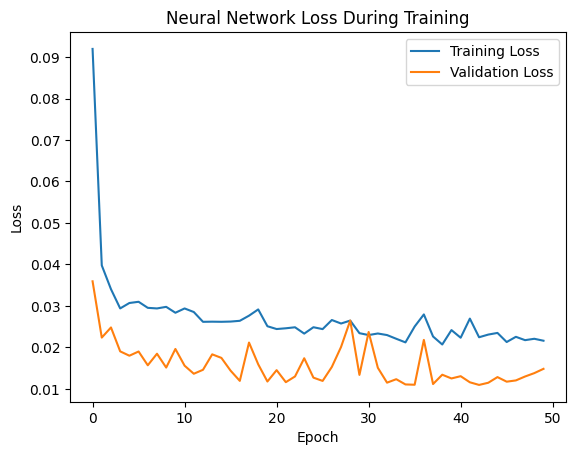

In [575]:
# Plotting the model's training and validation loss over the training period
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [569]:
# Predicting the future price using the neural network
predictions = model.predict(x_test_scaled_reshaped)
# y_test_reshaped = y_test.reshape(-1, 1)  # Reshape if needed

# Calculate mean squared error
mse = mean_squared_error(y_test_scaled_reshaped, predictions)

# Calculate R-squared
r2 = r2_score(y_test_scaled_reshaped, predictions)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

17/17 [==============================] - 3s 10ms/step
Mean Squared Error (MSE): 0.03488636769287325
R-squared (R2): -0.03416075684198172


In [570]:
predictions.reshape(-1, 1)

array([[0.60017186],
       [0.62631893],
       [0.6848301 ],
       [0.671193  ],
       [0.6849317 ],
       [0.62978905],
       [0.6343124 ],
       [0.6257429 ],
       [0.62442166],
       [0.65315795],
       [0.64353466],
       [0.6361764 ],
       [0.6211584 ],
       [0.5612974 ],
       [0.4997789 ],
       [0.48210722],
       [0.5059572 ],
       [0.5907616 ],
       [0.6247673 ],
       [0.58493114],
       [0.55961215],
       [0.5291099 ],
       [0.52164555],
       [0.52461725],
       [0.54761696],
       [0.54698956],
       [0.53491664],
       [0.52661324],
       [0.48037478],
       [0.40691555],
       [0.33937287],
       [0.23764837],
       [0.17389573],
       [0.15559961],
       [0.11790803],
       [0.0936171 ],
       [0.06611213],
       [0.0799778 ],
       [0.10909899],
       [0.12927143],
       [0.12091148],
       [0.12990475],
       [0.166543  ],
       [0.2006828 ],
       [0.20549107],
       [0.19699723],
       [0.17561123],
       [0.146

In [571]:
# Rescale the predictions
predictions_rescaled = y_scaler.inverse_transform(predictions)

In [572]:
test_date_truncated = test_date[TIMESTEP:]
test_date_truncated.shape

(533,)

In [573]:
y_test_truncated = y_test[TIMESTEP:]
y_test_truncated.shape

(533, 1)

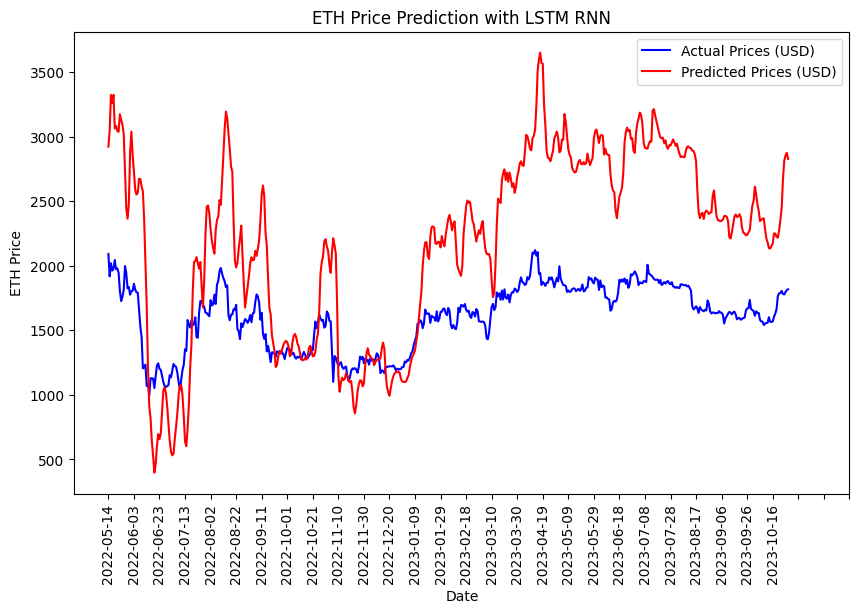

In [574]:
# Plotting performance
plt.figure(figsize = (10, 6))
plt.plot(test_date_truncated, y_test_truncated, label = "Actual Prices (USD)", color = "blue")
plt.plot(test_date_truncated, predictions_rescaled, label = "Predicted Prices (USD)", color = "red")

plt.title("ETH Price Prediction with LSTM RNN")
plt.xlabel("Date")
plt.ylabel("ETH Price")
plt.xticks(np.arange(0, 600, step=20),rotation=90) # ticks once every 20 days
plt.legend()

plt.show()

----------------

Accuracy here turned out to be a bit lower than with the regression model. Some ideas to improve the accuracy:
- More time to train and/or more hyperparameter tuning to dial in the accuracy
- More input data for training since this dataset is fairly small
- Try using additional features in my model such as Volume
- I also want to try approaching the problem differently altogether. Here I tried predicting the future price, which can be susceptible to a number of other factors that I didn't use in my model. What might make more sense is predicting the future returns instead. There are a few reasons why, but one important one is that when scaling the data, the values are within the range (0, 1). In practice, using that scaler on the testing data that the model hasn't seen before would cause the test data to go beyond the range of values that the model was trained on, which could hurt its accuracy. This is why I think in both models, the predicted price is noticeably lower than the actual price even though the shapes of the plots are fairly similar.